# Developing a unified representation of Alzheimer’s subtypes

# Part 5: Cluster Testing

After finding the unified representation and their significance, we want to know how robust they are and if the data-driven approach is biologically consisitant. 

Here I will perform 3 types of tests:
1. I will run the multimodal test set through each individual SuStaIn model and add the subtype for each modality, then I can assess the combinations per subject and see if they correspond with our unified representations.
2. 3 individual longitudinal test sets with the previous SuStaIn models (per their modality) and see if subjects get reassigned to the same subtype at different stages to assess model consistency.


## Import Packages

In [44]:
# import the python packages needed to generate simulated data for the tutorial
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats
from scipy.stats import spearmanr, linregress, shapiro, ttest_ind, mannwhitneyu, f_oneway, kruskal, chi2_contingency, fisher_exact, ttest_1samp, norm
import sklearn.model_selection
from collections import Counter
import sys
import shutil
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*figure layout has changed to tight.*")
from itertools import combinations, product
from pathlib import Path
import pickle
import re
import IPython.display as display



sys.path.insert(0,'/Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/')

Loading the old data to use the sustain models. 

In [2]:
# Define key columns and Column indicators for results of different modalities
rid = "RID"
dat = "EXAMDATE"
dx = "DIAGNOSIS_STRING"
diagnosis_num = "DIAGNOSIS" 
mmse_score = "MMSCORE" #memory scores - lower indicate more impairment
apoe4 = "APOE4" #presence of the gene APOE4
educ = "PTEDUCAT" #years of education
gender = "PTGENDER" #Gender- Male=1, Female=2
y_startadsym = "PTADBEG" #year of onset of AD symptoms
headsize_mri = "ICV_CorticalVolume" #overall headsize
y_of_birth = "PTDOBYY"
age = "Age"
retire_age = "AGE_RETIRE"
retirement = "PTNOTRT" #retired = 1, not retired = 0
y_retirement = "PTRTYR" #year of retirement


continuous_vars = [age, mmse_score, educ, retire_age]
categorical_vars = [dx, gender, apoe4]


#Sustain data per modality
N_startpoints = 50
N_iterations_MCMC = int(1e5)

#MRI
zdata_mri = pd.read_csv("Train_MRI_SuStaIn_1.csv")
biomarkers_mri = zdata_mri.columns[11:16]
N_mri = len(biomarkers_mri)         # number of biomarkers
SuStaInLabels_mri = biomarkers_mri
Z_vals_mri = np.array([[2,3,4.5]]*N_mri)     # Z-scores for each biomarker
Z_max_mri  = np.ceil(np.percentile(zdata_mri[biomarkers_mri].values,99,axis=0)).astype('int')           # maximum z-score
N_S_max_mri = 4
N_iterations_MCMC = int(1e5)
output_folder_mri = os.path.join(os.getcwd(), 'MRIOutput')
dataset_name_mri = 'MRIOutput'

sustain_input_mri = pySuStaIn.ZscoreSustain(
                              zdata_mri[biomarkers_mri].values,
                              Z_vals_mri,
                              Z_max_mri,
                              SuStaInLabels_mri,
                              N_startpoints,
                              N_S_max_mri, 
                              N_iterations_MCMC, 
                              output_folder_mri, 
                              dataset_name_mri, 
                              False)
pickle_filename_s_mri = output_folder_mri + '/pickle_files/' + dataset_name_mri + '_subtype' + str(N_S_max_mri-1) + '.pickle'
pk_mri = pd.read_pickle(pickle_filename_s_mri)
samples_sequence_mri = pk_mri["samples_sequence"]
samples_f_mri = pk_mri["samples_f"]
pickle_filepath_mri             = Path(pickle_filename_s_mri)
pickle_file_mri                 = open(pickle_filename_s_mri, 'rb')
loaded_variables_mri            = pickle.load(pickle_file_mri)
ml_subtype_mri                  = loaded_variables_mri["ml_subtype"]
prob_ml_subtype_mri             = loaded_variables_mri["prob_ml_subtype"]
ml_stage_mri                    = loaded_variables_mri["ml_stage"]
prob_ml_stage_mri               = loaded_variables_mri["prob_ml_stage"]
prob_subtype_mri                = loaded_variables_mri["prob_subtype"]
prob_stage_mri                  = loaded_variables_mri["prob_stage"]
prob_subtype_stage_mri          = loaded_variables_mri["prob_subtype_stage"]
pickle_file_mri.close()    

#AB
zdata_ab = pd.read_csv("Train_AB_SuStaIn_2.csv")
biomarkers_ab = zdata_ab.columns[10:15]
N_ab = len(biomarkers_ab)         # number of biomarkers
SuStaInLabels_ab = biomarkers_ab
Z_vals_ab = np.array([[1,2,3.5]]*N_ab)     # Z-scores for each biomarker
Z_max_ab  = np.ceil(np.percentile(zdata_ab[biomarkers_ab].values,99,axis=0)).astype('int')           # maximum z-score
N_S_max_ab = 2
output_folder_ab = os.path.join(os.getcwd(), 'ABOutput')
dataset_name_ab = 'ABOutput'
sustain_input_ab = pySuStaIn.ZscoreSustain(
                              zdata_ab[biomarkers_ab].values,
                              Z_vals_ab,
                              Z_max_ab,
                              SuStaInLabels_ab,
                              N_startpoints,
                              N_S_max_ab, 
                              N_iterations_MCMC, 
                              output_folder_ab, 
                              dataset_name_ab, 
                              False)
pickle_filename_s_ab = output_folder_ab + '/pickle_files/' + dataset_name_ab + '_subtype' + str(N_S_max_ab-1) + '.pickle'
pk_ab = pd.read_pickle(pickle_filename_s_ab)
samples_sequence_ab = pk_ab["samples_sequence"]
samples_f_ab = pk_ab["samples_f"]

pickle_filepath_ab             = Path(pickle_filename_s_ab)
pickle_file_ab                 = open(pickle_filename_s_ab, 'rb')
loaded_variables_ab            = pickle.load(pickle_file_ab)
ml_subtype_ab                  = loaded_variables_ab["ml_subtype"]
prob_ml_subtype_ab             = loaded_variables_ab["prob_ml_subtype"]
ml_stage_ab                    = loaded_variables_ab["ml_stage"]
prob_ml_stage_ab               = loaded_variables_ab["prob_ml_stage"]
prob_subtype_ab                = loaded_variables_ab["prob_subtype"]
prob_stage_ab                  = loaded_variables_ab["prob_stage"]
prob_subtype_stage_ab          = loaded_variables_ab["prob_subtype_stage"]
pickle_file_ab.close()              


#TAU
zdata_tau = pd.read_csv("Train_TAU_SuStaIn_3.csv")
biomarkers_tau = zdata_tau.columns[10:15]
N_tau = len(biomarkers_tau)         # number of biomarkers
SuStaInLabels_tau = biomarkers_tau
Z_vals_tau = np.array([[3,5,6.5]]*N_tau)     # Z-scores for each biomarker
Z_max_tau  = np.ceil(np.nanpercentile(zdata_tau[biomarkers_tau].values,99,axis=0)).astype('int')           # maximum z-score
N_S_max_tau = 4
output_folder_tau = os.path.join(os.getcwd(), 'TAUOutput')
dataset_name_tau = 'TAUOutput'
sustain_input_tau = pySuStaIn.ZscoreSustain(
                              zdata_tau[biomarkers_tau].values,
                              Z_vals_tau,
                              Z_max_tau,
                              SuStaInLabels_tau,
                              N_startpoints,
                              N_S_max_tau, 
                              N_iterations_MCMC, 
                              output_folder_tau, 
                              dataset_name_tau, 
                              False)
pickle_filename_s_tau = output_folder_tau + '/pickle_files/' + dataset_name_tau + '_subtype' + str(N_S_max_tau-1) + '.pickle'
pk_tau = pd.read_pickle(pickle_filename_s_tau)
samples_sequence_tau = pk_tau["samples_sequence"]
samples_f_tau = pk_tau["samples_f"]

pickle_filepath_tau             = Path(pickle_filename_s_tau)
pickle_file_tau                 = open(pickle_filename_s_tau, 'rb')
loaded_variables_tau            = pickle.load(pickle_file_tau)
ml_subtype_tau                  = loaded_variables_tau["ml_subtype"]
prob_ml_subtype_tau             = loaded_variables_tau["prob_ml_subtype"]
ml_stage_tau                    = loaded_variables_tau["ml_stage"]
prob_ml_stage_tau               = loaded_variables_tau["prob_ml_stage"]
prob_subtype_tau                = loaded_variables_tau["prob_subtype"]
prob_stage_tau                  = loaded_variables_tau["prob_stage"]
prob_subtype_stage_tau          = loaded_variables_tau["prob_subtype_stage"]
pickle_file_tau.close()              


## 1. Multimodal Testset
Load new data and assign the correct columns for the biomarkers. 

In [3]:
data_multi = pd.read_csv("Test_Multi_Modality_4.csv")
print(f"Multimodal: {data_multi.DIAGNOSIS_STRING.value_counts()}\n")

# store biomarker labels as a variable
biomarkers_mri = data_multi.columns[11:16]
print(biomarkers_mri)

biomarkers_ab = data_multi.columns[26:31]
print(biomarkers_ab)

biomarkers_tau = data_multi.columns[41:46]
print(biomarkers_tau)


Multimodal: DIAGNOSIS_STRING
CN          181
MCI          90
Dementia     34
Name: count, dtype: int64

Index(['Frontal_lobe_volume', 'Occipital_lobe_volume', 'Parietal_lobe_volume',
       'Temporal_lobe_volume', 'MTL_volume'],
      dtype='object')
Index(['Frontal_lobe_SUVR_weighted_ab', 'Occipital_lobe_SUVR_weighted_ab',
       'Parietal_lobe_SUVR_weighted_ab', 'Temporal_lobe_SUVR_weighted_ab',
       'MTL_SUVR_weighted_ab'],
      dtype='object')
Index(['Frontal_lobe_SUVR_weighted_tau', 'Occipital_lobe_SUVR_weighted_tau',
       'Parietal_lobe_SUVR_weighted_tau', 'Temporal_lobe_SUVR_weighted_tau',
       'MTL_SUVR_weighted_tau'],
      dtype='object')


We need to normalise the new data the same way we normalised per modality. 

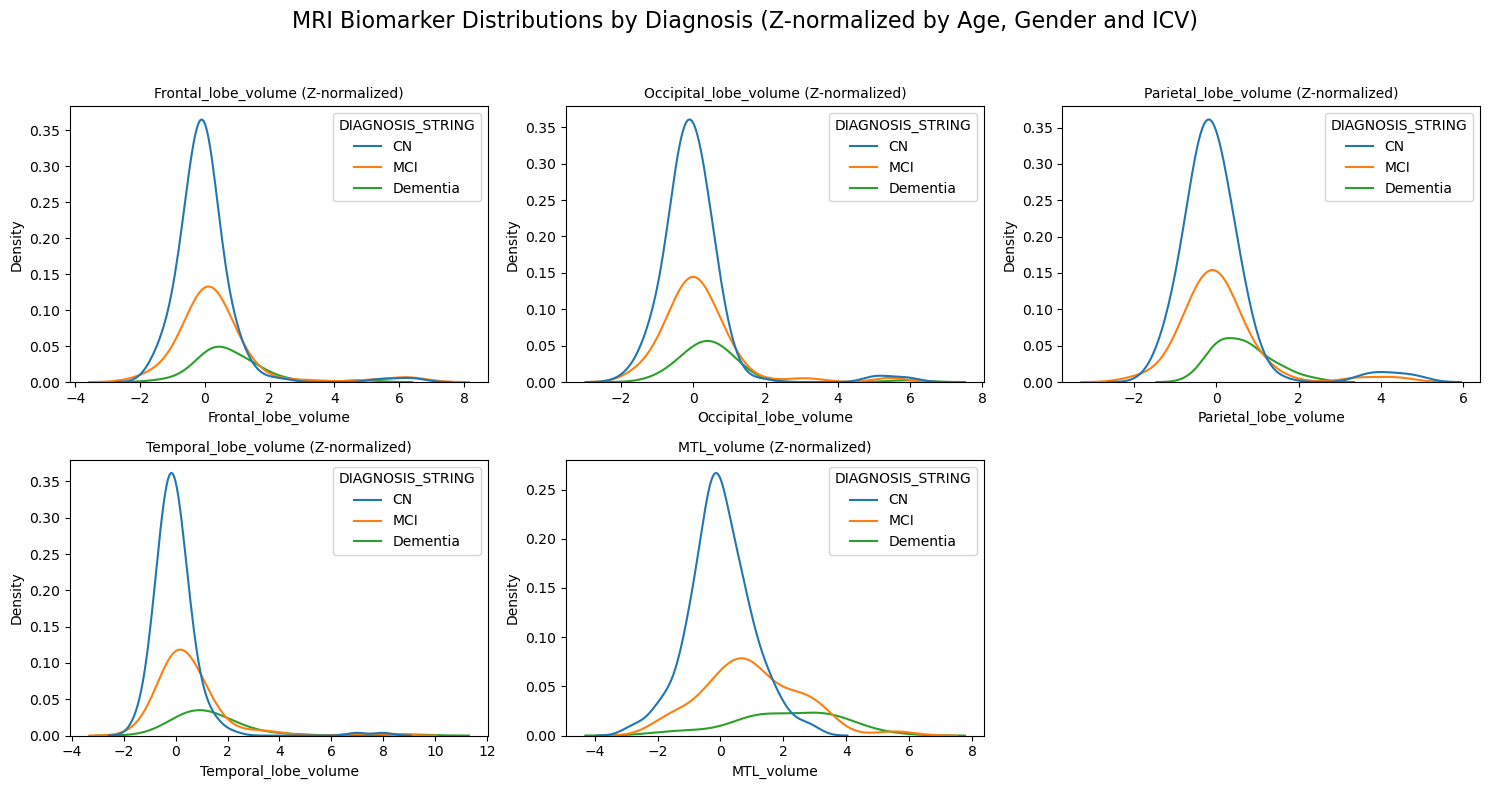

In [4]:
#Normalisation of the Multi MRI data 

# Make a copy of data_mri to store normalized values
zdata_multi_mri = pd.DataFrame(data_multi.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_mri: 
    model = smf.wls(f'{biomarker} ~ Age + ICV_CorticalVolume + C(PTGENDER)', data=data_multi[data_multi['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_multi[['Age', 'ICV_CorticalVolume', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_multi[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_multi['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_multi['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_multi_mri[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_mri)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_mri):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_multi_mri, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("MRI Biomarker Distributions by Diagnosis (Z-normalized by Age, Gender and ICV)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



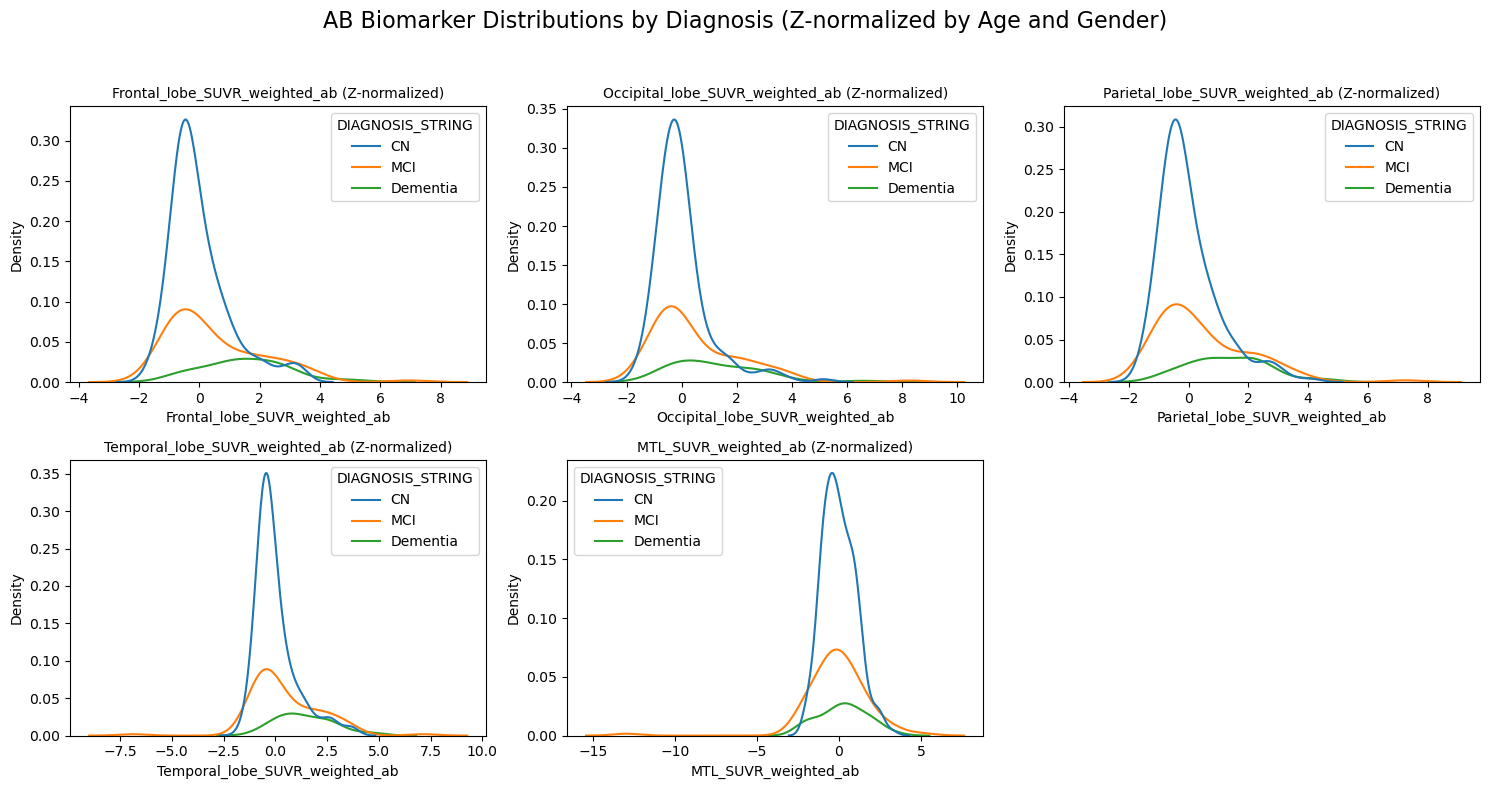

In [5]:
#Normalisation of the Multi AB data 

# Make a copy of data_mri to store normalized values
zdata_multi_ab = pd.DataFrame(data_multi.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_ab: 
    model = smf.wls(f'{biomarker} ~ Age + C(PTGENDER)', data=data_multi[data_multi['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_multi[['Age', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_multi[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_multi['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_multi['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_multi_ab[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_ab)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_ab):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_multi_ab, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("AB Biomarker Distributions by Diagnosis (Z-normalized by Age and Gender)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


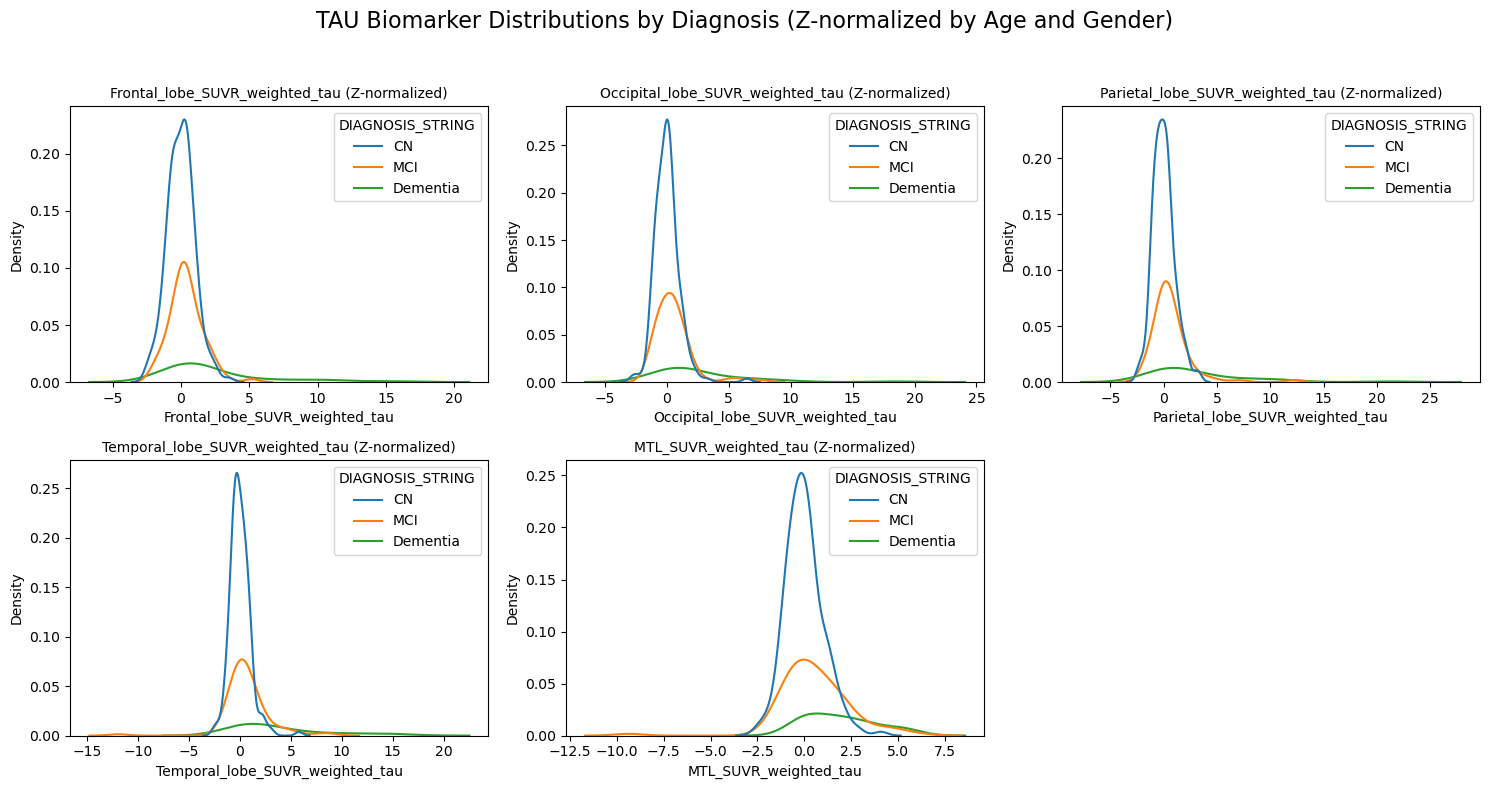

In [6]:
#Normalisation of the Multi TAU data 

# Make a copy of data_mri to store normalized values
zdata_multi_tau = pd.DataFrame(data_multi.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_tau: 
    model = smf.wls(f'{biomarker} ~ Age + C(PTGENDER)', data=data_multi[data_multi['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_multi[['Age', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_multi[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_multi['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_multi['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_multi_tau[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_tau)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_tau):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_multi_tau, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("TAU Biomarker Distributions by Diagnosis (Z-normalized by Age and Gender)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


We load the data and run the same normalisations as before. Then we can load the data into the existing sustain models and assess subjects assignment over time. 

In [7]:
#Run the new data into the old models and assign subtype and stage per indivividual

N_samples = 1000 

def assign_sustain_subtypes(zdata_modality, biomarkers, sustain_model, samples_sequence, samples_f, modality_label, N_samples=1000):
    """Assign SuStaIn subtype/stage and return labels and full probability matrices."""
    zdata_array = zdata_modality[biomarkers].values

    ml_subtype, \
    prob_ml_subtype, \
    ml_stage, \
    prob_ml_stage, \
    prob_subtype, \
    prob_stage, \
    prob_subtype_stage = sustain_model.subtype_and_stage_individuals_newData(
        zdata_array, samples_sequence, samples_f, N_samples
    )

    # Flatten for DataFrame
    df_results = pd.DataFrame({
        f"{modality_label}_ml_subtype": np.ravel(ml_subtype),
        f"{modality_label}_ml_stage": np.ravel(ml_stage),
        f"{modality_label}_prob_ml_subtype": np.ravel(prob_ml_subtype),
        f"{modality_label}_prob_ml_stage": np.ravel(prob_ml_stage)
    }, index=zdata_modality.index)

    # Return all
    return df_results, prob_subtype, prob_stage, prob_subtype_stage


# Assign subtypes/stages for each modality
results_mri, prob_mri_subtype, prob_mri_stage, prob_mri_subtype_stage = assign_sustain_subtypes(zdata_multi_mri, biomarkers_mri, sustain_input_mri, samples_sequence_mri, samples_f_mri, "mri")
results_ab, prob_ab_subtype, prob_ab_stage, prob_ab_subtype_stage = assign_sustain_subtypes(zdata_multi_ab, biomarkers_ab, sustain_input_ab, samples_sequence_ab, samples_f_ab, "ab")
results_tau, prob_tau_subtype, prob_tau_stage, prob_tau_subtype_stage = assign_sustain_subtypes(zdata_multi_tau, biomarkers_tau, sustain_input_tau, samples_sequence_tau, samples_f_tau, "tau")

# Combine all SuStaIn assignments
results_combined = pd.concat([results_mri, results_ab, results_tau], axis=1)

# Merge with the full data_multi if needed
final_combined_df = pd.concat([data_multi, results_combined], axis=1)

final_combined_df["subtype_combo"] = ( "AB" +
    final_combined_df["ab_ml_subtype"].astype(str) + "_TAU" +
    final_combined_df["tau_ml_subtype"].astype(str) + "_MRI" +
    final_combined_df["mri_ml_subtype"].astype(str) 
)

def clean_and_increment_subtype_combo(combo_str):
    # Convert something like 'AB1.0_TAU2.0_MRI0.0' to 'AB2_TAU3_MRI1'
    parts = combo_str.split('_')
    cleaned_parts = []
    for part in parts:
        match = re.match(r'([A-Za-z]+)(\d+\.?\d*)', part)
        if match:
            label = match.group(1)
            number = int(float(match.group(2))) + 1  # force to int, then increment
            cleaned_parts.append(f"{label}{number}")
        else:
            cleaned_parts.append(part)  # fallback
    return '_'.join(cleaned_parts)
final_combined_df["subtype_combo"] = final_combined_df["subtype_combo"].apply(clean_and_increment_subtype_combo)



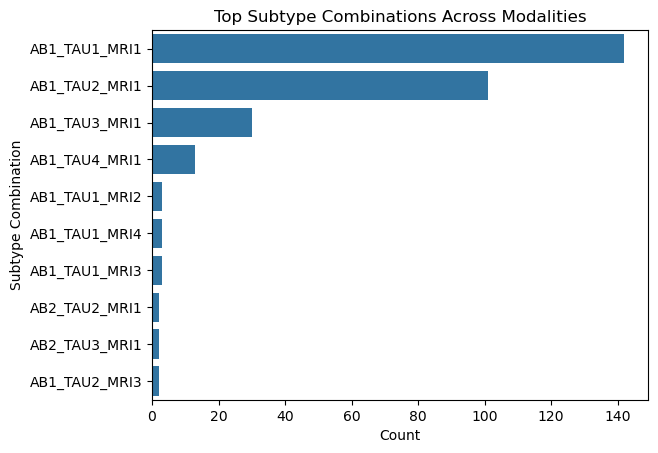

                 Count                          Proportion              \
DIAGNOSIS_STRING    CN Dementia MCI n_subjects          CN    Dementia   
subtype_combo                                                            
AB1_TAU1_MRI1       91       11  40        142   64.084507    7.746479   
AB1_TAU2_MRI1       69        6  26        101   68.316832    5.940594   
AB1_TAU3_MRI1        6       11  13         30   20.000000   36.666667   
AB1_TAU4_MRI1        5        3   5         13   38.461538   23.076923   
AB1_TAU1_MRI2        2        0   1          3   66.666667    0.000000   
AB1_TAU1_MRI3        1        0   2          3   33.333333    0.000000   
AB1_TAU1_MRI4        3        0   0          3  100.000000    0.000000   
AB1_TAU2_MRI3        1        0   1          2   50.000000    0.000000   
AB2_TAU2_MRI1        1        0   1          2   50.000000    0.000000   
AB2_TAU3_MRI1        0        1   1          2    0.000000   50.000000   
AB2_TAU4_MRI1        1        1   0   

In [8]:

#Count and visualise common subtype combinations
combo_counts = final_combined_df["subtype_combo"].value_counts()
#print(combo_counts.head(10))

top_combos = combo_counts.head(10).reset_index()
top_combos.columns = ["Subtype Combination", "Count"]
sns.barplot(x="Count", y="Subtype Combination", data=top_combos)
plt.title("Top Subtype Combinations Across Modalities")
plt.show()

#Association with Diagnosis
crosstab_counts = pd.crosstab(final_combined_df["subtype_combo"], final_combined_df[dx]) # Crosstab: raw counts
crosstab_props = pd.crosstab(final_combined_df["subtype_combo"], final_combined_df[dx], normalize='index') * 100 # Crosstab: row-normalized percentages
crosstab_counts["n_subjects"] = crosstab_counts.sum(axis=1) # Add total number of subjects per subtype_combo
# Sort by total number of subjects per subtype_combo
crosstab_counts_sorted = crosstab_counts.sort_values("n_subjects", ascending=False)

# Get corresponding rows for proportions
crosstab_props_sorted = crosstab_props.loc[crosstab_counts_sorted.index]

# Combine sorted tables
combined_table = pd.concat(
    [crosstab_counts_sorted, crosstab_props_sorted],
    axis=1,
    keys=["Count", "Proportion"]
)
print(combined_table)


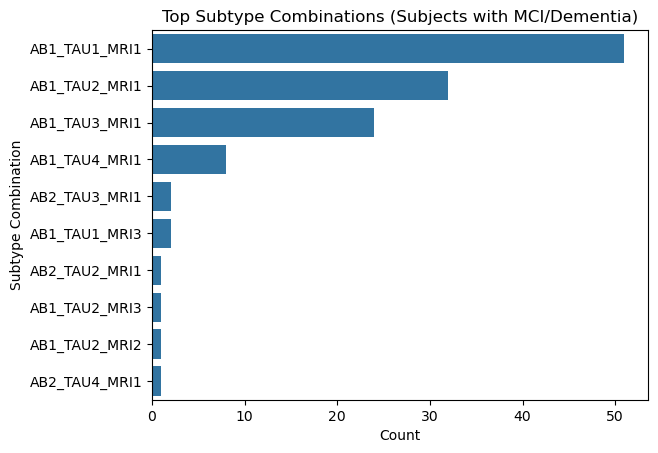

                    Count                 Proportion            
DIAGNOSIS_STRING Dementia MCI n_subjects    Dementia         MCI
subtype_combo                                                   
AB1_TAU1_MRI1          11  40         51   21.568627   78.431373
AB1_TAU2_MRI1           6  26         32   18.750000   81.250000
AB1_TAU3_MRI1          11  13         24   45.833333   54.166667
AB1_TAU4_MRI1           3   5          8   37.500000   62.500000
AB1_TAU1_MRI3           0   2          2    0.000000  100.000000
AB2_TAU3_MRI1           1   1          2   50.000000   50.000000
AB1_TAU1_MRI2           0   1          1    0.000000  100.000000
AB1_TAU2_MRI2           1   0          1  100.000000    0.000000
AB1_TAU2_MRI3           0   1          1    0.000000  100.000000
AB2_TAU2_MRI1           0   1          1    0.000000  100.000000
AB2_TAU4_MRI1           1   0          1  100.000000    0.000000


In [9]:
# modalities = ['mri', 'tau', 'ab']
# stage_cols = [f"{mod}_ml_stage" for mod in modalities]

# # Filter to keep only rows where all stages > 0 (i.e., exclude any with 0 stage in any modality)
# filtered_df = final_combined_df[
#     (final_combined_df[stage_cols] > 0).all(axis=1)
# ]

filtered_df = final_combined_df[final_combined_df[dx] != 'CN']


import seaborn as sns
import matplotlib.pyplot as plt

# Count subtype combos in filtered data
combo_counts = filtered_df["subtype_combo"].value_counts()

top_combos = combo_counts.head(10).reset_index()
top_combos.columns = ["Subtype Combination", "Count"]

# Plot barplot
sns.barplot(x="Count", y="Subtype Combination", data=top_combos)
plt.title("Top Subtype Combinations (Subjects with MCI/Dementia)")
plt.show()

# Crosstab counts and proportions on filtered_df
crosstab_counts = pd.crosstab(filtered_df["subtype_combo"], filtered_df[dx])  # raw counts
crosstab_props = pd.crosstab(filtered_df["subtype_combo"], filtered_df[dx], normalize='index') * 100  # row-wise %

crosstab_counts["n_subjects"] = crosstab_counts.sum(axis=1)
crosstab_counts_sorted = crosstab_counts.sort_values("n_subjects", ascending=False)
crosstab_props_sorted = crosstab_props.loc[crosstab_counts_sorted.index]

combined_table = pd.concat(
    [crosstab_counts_sorted, crosstab_props_sorted],
    axis=1,
    keys=["Count", "Proportion"]
)

print(combined_table)


In [10]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, f_oneway, kruskal, chi2_contingency, shapiro, norm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools

# --- EFFECT SIZE FUNCTIONS ---

def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / dof)

def eta_squared(f_val, df_tuple):
    df1, df2 = df_tuple
    return f_val * df1 / (f_val * df1 + df2)

def epsilon_squared(H, N, k):
    return (H - k + 1) / (N - k)

# --- CRAMER'S V FOR CATEGORICAL ASSOCIATION ---

def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# --- POST-HOC MANN-WHITNEY WITH BONFERRONI ---

def pairwise_posthoc_mannwhitney(df, value_col, group_col, alpha=0.05):
    """Performs pairwise Mann-Whitney U test with Bonferroni correction."""
    results = []
    groups = df[group_col].unique()
    combinations = list(itertools.combinations(groups, 2))
    m = len(combinations)

    for g1, g2 in combinations:
        x = df[df[group_col] == g1][value_col]
        y = df[df[group_col] == g2][value_col]
        stat, p = mannwhitneyu(x, y)
        p_adj = min(p * m, 1.0)
        results.append({
            'Group 1': g1,
            'Group 2': g2,
            'p': p,
            'p_adj': p_adj,
            'significant': p_adj < alpha
        })

    return pd.DataFrame(results)




====== Multimodal Triplet Subtype Analysis (4 triplets) ======

 AGE (Continuous)
  Group sizes: {'AB1_TAU1_MRI1': 142, 'AB1_TAU2_MRI1': 101, 'AB1_TAU3_MRI1': 30, 'AB1_TAU4_MRI1': 13}
→ ANOVA p = 0.0399 | Eta² = 0.029

Tukey HSD post hoc results:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
AB1_TAU1_MRI1 AB1_TAU2_MRI1  -2.3227 0.0639 -4.7352 0.0898  False
AB1_TAU1_MRI1 AB1_TAU3_MRI1   0.3469 0.9951 -3.3772 4.0711  False
AB1_TAU1_MRI1 AB1_TAU4_MRI1   1.5341 0.8816 -3.8364 6.9047  False
AB1_TAU2_MRI1 AB1_TAU3_MRI1   2.6696 0.2801 -1.1841 6.5234  False
AB1_TAU2_MRI1 AB1_TAU4_MRI1   3.8568 0.2636 -1.6044  9.318  False
AB1_TAU3_MRI1 AB1_TAU4_MRI1   1.1872 0.9593  -4.967 7.3414  False
-----------------------------------------------------------------


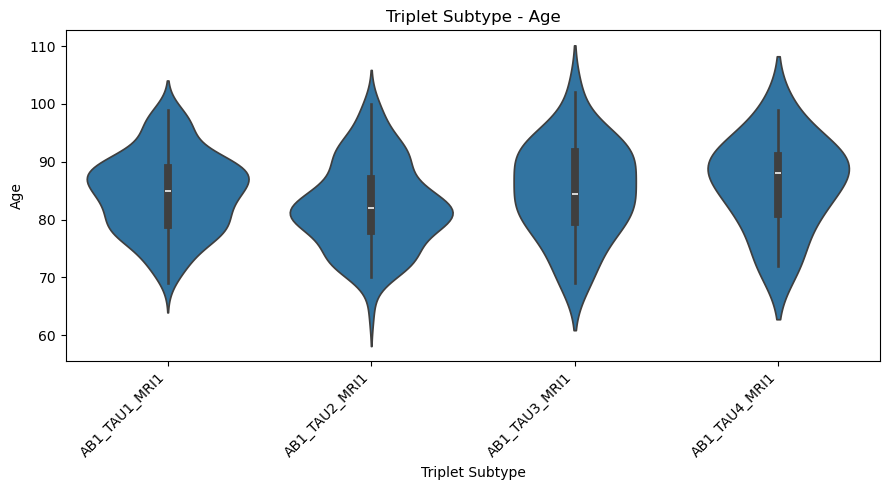


 MMSCORE (Continuous)
  Group sizes: {'AB1_TAU1_MRI1': 142, 'AB1_TAU2_MRI1': 100, 'AB1_TAU3_MRI1': 30, 'AB1_TAU4_MRI1': 13}
→ Kruskal-Wallis p = 0.0000 | Epsilon² = 0.086

Post hoc pairwise Mann-Whitney U test results (Bonferroni corrected):
         Group 1        Group 2         p     p_adj  significant
1  AB1_TAU1_MRI1  AB1_TAU3_MRI1  0.000001  0.000008         True
3  AB1_TAU2_MRI1  AB1_TAU3_MRI1  0.000003  0.000020         True


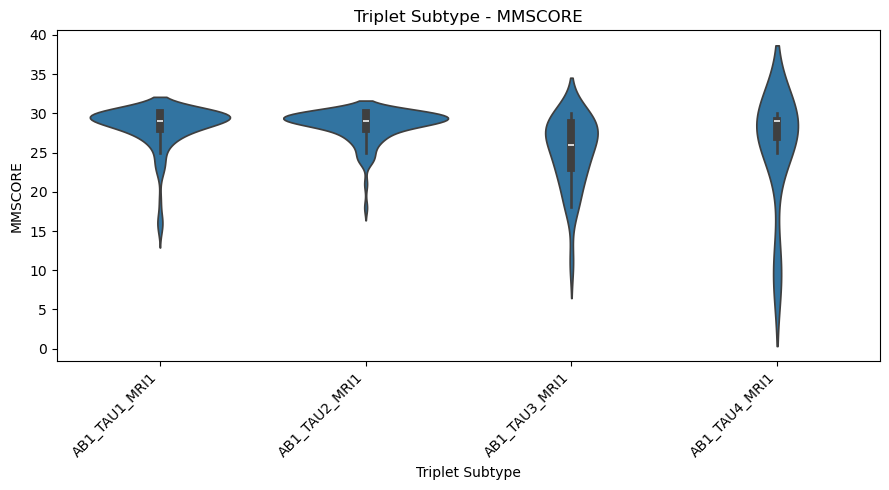


 PTEDUCAT (Continuous)
  Group sizes: {'AB1_TAU1_MRI1': 142, 'AB1_TAU2_MRI1': 101, 'AB1_TAU3_MRI1': 30, 'AB1_TAU4_MRI1': 13}
→ Kruskal-Wallis p = 0.0982 | Epsilon² = 0.012


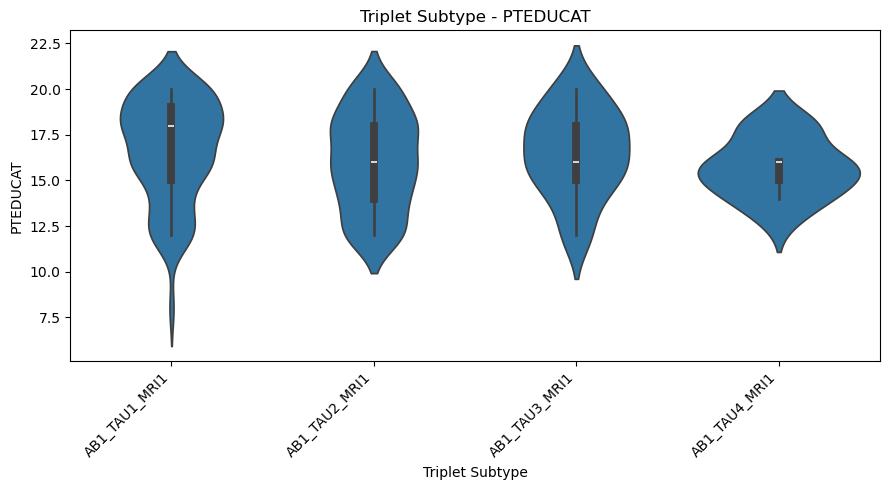


 AGE_RETIRE (Continuous)
  Group sizes: {'AB1_TAU1_MRI1': 102, 'AB1_TAU2_MRI1': 73, 'AB1_TAU3_MRI1': 27, 'AB1_TAU4_MRI1': 12}
→ Kruskal-Wallis p = 0.3612 | Epsilon² = 0.001


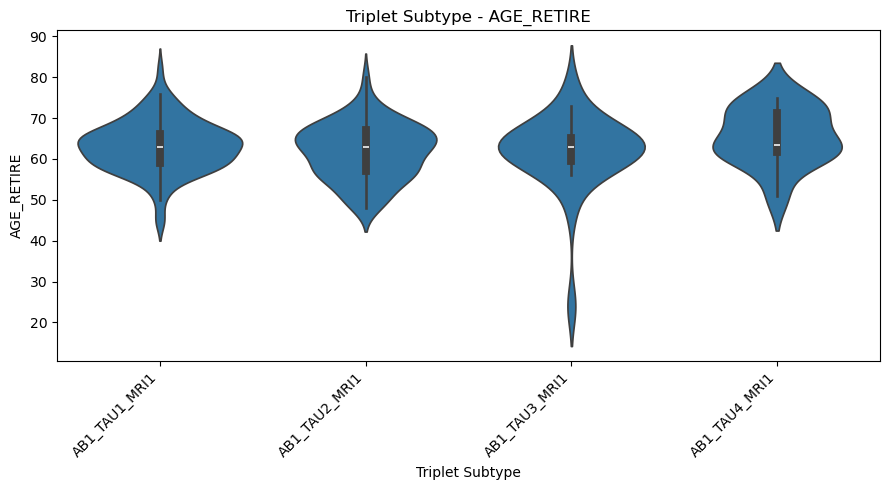


 DIAGNOSIS_STRING (Categorical)
→ Chi-squared p = 0.0000 | Cramér’s V = 0.255

Post hoc (adjusted residuals with Bonferroni correction):
         Subtype DIAGNOSIS_STRING         p     p_adj        direction
7  AB1_TAU3_MRI1         Dementia  0.000017  0.000208  Overrepresented


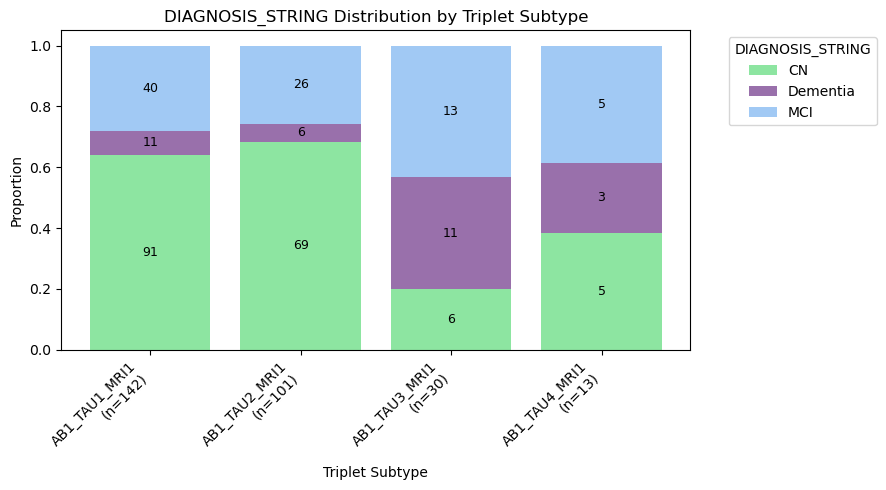


 PTGENDER (Categorical)
→ Chi-squared p = 0.2195 | Cramér’s V = 0.124


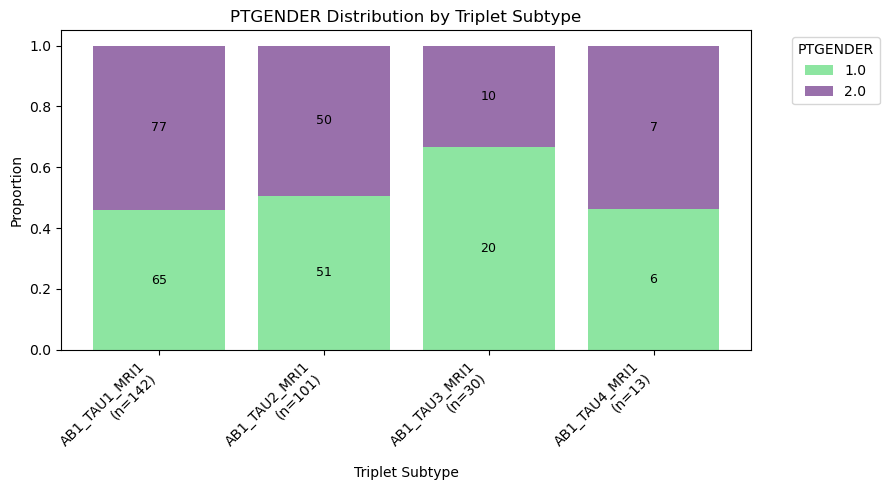


 APOE4 (Categorical)
→ Chi-squared p = 0.1077 | Cramér’s V = 0.135


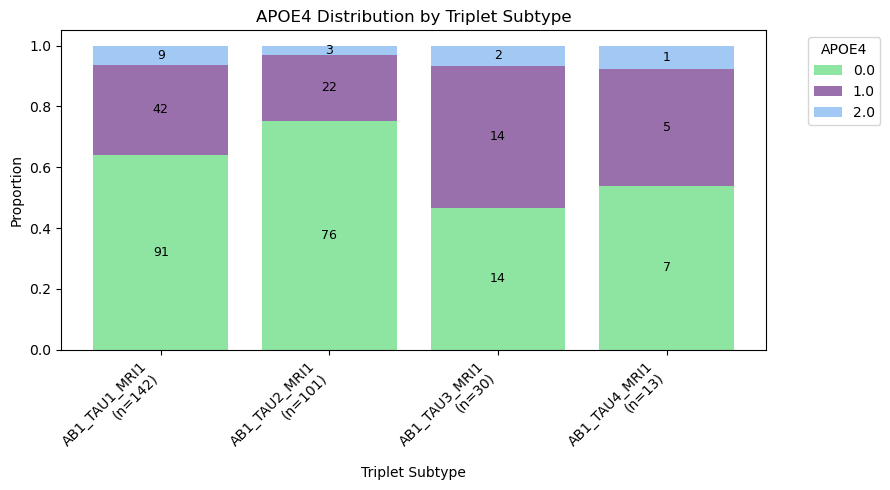

In [11]:
def triplet_subtype_analysis(df, combo_col, continuous_vars, categorical_vars, mmse_score, retire_age):
    colors = ['#8de5a1', '#9970AB', '#a1c9f4', '#ffb482', '#ff9f9b', '#d0bbff']

    # Filter triplets with >=10 subjects
    triplet_counts = df[combo_col].value_counts()
    valid_triplets = triplet_counts[triplet_counts >= 10].index.tolist()
    df = df[df[combo_col].isin(valid_triplets)]
    triplets = sorted(valid_triplets)
    k = len(triplets)

    if k < 2:
        print("Not enough valid triplets with ≥10 subjects. Aborting.")
        return

    print(f"\n\n====== Multimodal Triplet Subtype Analysis ({k} triplets) ======")

    # CONTINUOUS VARIABLES
    for var in continuous_vars:
        print(f"\n {var.upper()} (Continuous)")
        df_var = df.dropna(subset=[var, combo_col])

        if var == mmse_score:
            df_var = df_var[df_var[var] > 0]
        if var == retire_age:
            df_var = df_var[df_var[var] > 0]

        grouped = [df_var[df_var[combo_col] == s][var] for s in triplets]
        sizes = [len(g) for g in grouped]
        print(f"  Group sizes: {dict(zip(triplets, sizes))}")
        if any(n < 5 for n in sizes):
            print(" Small sample size detected in at least one group.")

        normal = all(shapiro(g)[1] > 0.05 for g in grouped if len(g) >= 3)

        if k == 2:
            x, y = grouped
            if normal:
                stat, p = ttest_ind(x, y, equal_var=False)
                d = cohen_d(x, y)
                print(f"→ Welch's t-test p = {p:.4f} | Cohen’s d = {d:.3f}")
            else:
                stat, p = mannwhitneyu(x, y)
                print(f"→ Mann-Whitney U test p = {p:.4f}")
        else:
            if normal:
                stat, p = f_oneway(*grouped)
                df1, df2 = k - 1, len(df_var) - k
                eta2 = eta_squared(stat, (df1, df2))
                print(f"→ ANOVA p = {p:.4f} | Eta² = {eta2:.3f}")
                if p < 0.05:
                    tukey_data = pd.concat([
                        pd.Series(g, name=var).to_frame().assign(subtype=s)
                        for g, s in zip(grouped, triplets)
                    ])
                    tukey = pairwise_tukeyhsd(tukey_data[var], tukey_data['subtype'])
                    print("\nTukey HSD post hoc results:")
                    print(tukey.summary())
            else:
                stat, p = kruskal(*grouped)
                eps2 = epsilon_squared(stat, len(df_var), k)
                print(f"→ Kruskal-Wallis p = {p:.4f} | Epsilon² = {eps2:.3f}")
                if p < 0.05:
                    posthoc_results = pairwise_posthoc_mannwhitney(df_var, var, combo_col)
                    sig_pairs = posthoc_results[posthoc_results['significant']]
                    print("\nPost hoc pairwise Mann-Whitney U test results (Bonferroni corrected):")
                    print(sig_pairs if not sig_pairs.empty else "No significant pairwise differences found.")

        # Plot
        plt.figure(figsize=(9, 5))
        sns.violinplot(x=combo_col, y=var, data=df_var)
        plt.title(f'Triplet Subtype - {var}')
        plt.xlabel("Triplet Subtype")
        plt.ylabel(var)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # CATEGORICAL VARIABLES
    for var in categorical_vars:
        print(f"\n {var.upper()} (Categorical)")
        if df[var].isnull().all():
            print(" Variable missing entirely.")
            continue

        table = pd.crosstab(df[combo_col], df[var])
        chi2, p, _, expected = chi2_contingency(table, correction=False)
        v = cramers_v(table)
        print(f"→ Chi-squared p = {p:.4f} | Cramér’s V = {v:.3f}")

        if p < 0.05:
            print("\nPost hoc (adjusted residuals with Bonferroni correction):")
            residuals = (table - expected) / np.sqrt(expected)
            flattened = residuals.stack().reset_index()
            flattened.columns = ['Subtype', var, 'z']
            flattened['p'] = 2 * (1 - norm.cdf(np.abs(flattened['z'])))
            flattened['p_adj'] = np.minimum(flattened['p'] * len(flattened), 1.0)
            sig = flattened[flattened['p_adj'] < 0.05].copy()

            if not sig.empty:
                sig['direction'] = np.where(sig['z'] > 0, 'Overrepresented', 'Underrepresented')
                sig = sig.sort_values('p_adj')
                print(sig[['Subtype', var, 'p', 'p_adj', 'direction']])
            else:
                print("No significant residuals after correction.")

        # Barplot
        prop_df = table.div(table.sum(1), axis=0)
        subtype_counts = table.sum(axis=1)
        new_labels = [f"{s}\n(n={n})" for s, n in subtype_counts.items()]

        fig, ax = plt.subplots(figsize=(9, 5))
        bottom = np.zeros(len(prop_df))

        for i, category in enumerate(prop_df.columns):
            proportions = prop_df[category].values
            counts = table[category].values
            bars = ax.bar(
                x=np.arange(len(prop_df)),
                height=proportions,
                bottom=bottom,
                label=category,
                color=colors[i % len(colors)]
            )

            for j, bar in enumerate(bars):
                count = counts[j]
                if count > 0:
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        bar.get_y() + bar.get_height() / 2,
                        f'{int(count)}',
                        ha='center', va='center',
                        fontsize=9,
                        color='black'
                    )
            bottom += proportions

        ax.set_title(f'{var} Distribution by Triplet Subtype')
        ax.set_ylabel("Proportion")
        ax.set_xlabel("Triplet Subtype")
        ax.set_xticks(range(len(new_labels)))
        ax.set_xticklabels(new_labels, rotation=45, ha='right')
        ax.legend(title=var, bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.show()

triplet_subtype_analysis(
    final_combined_df,
    combo_col='subtype_combo',
    continuous_vars=continuous_vars,
    categorical_vars=categorical_vars,
    mmse_score=mmse_score,  # or your MMSE column name
    retire_age=retire_age  # or your retirement age column name
)


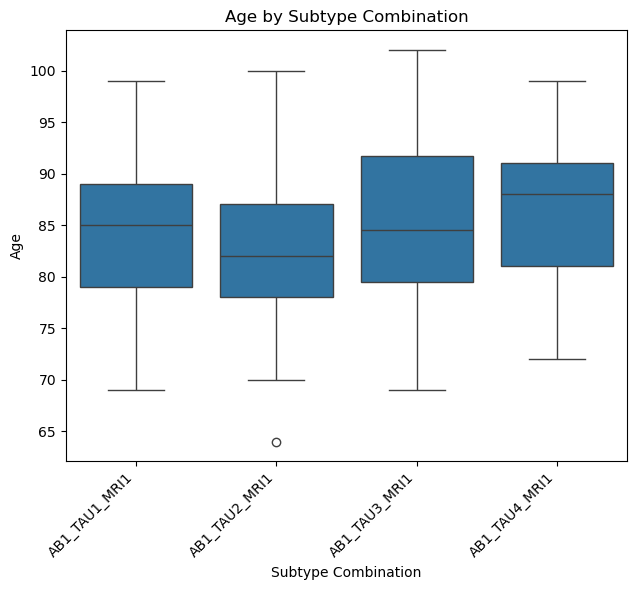


Subtype Combo Age Summary:
                  n   mean   std  median  min  max
subtype_combo                                    
AB1_TAU1_MRI1  142  84.62  6.79    85.0   69   99
AB1_TAU2_MRI1  101  82.30  7.37    82.0   64  100
AB1_TAU3_MRI1   30  84.97  8.01    84.5   69  102
AB1_TAU4_MRI1   13  86.15  7.70    88.0   72   99


In [12]:
# Define custom summary stats function if not already done
def stats(df, group_col, value_col):
    return (
        df.groupby(group_col)[value_col]
        .agg(['count', 'mean', 'std', 'median', 'min', 'max'])
        .rename(columns={'count': 'n'})
        .round(2)
    )

# Clean age > 0
multi_clean = final_combined_df[final_combined_df[age] > 0].copy()

# Keep only subtype combinations with >9 subjects
combo_counts = multi_clean['subtype_combo'].value_counts()
valid_combos = combo_counts[combo_counts > 9].index.tolist()
multi_clean = multi_clean[multi_clean['subtype_combo'].isin(valid_combos)]

# Plot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(data=multi_clean, x='subtype_combo', y=age)
plt.title('Age by Subtype Combination')
plt.xlabel('Subtype Combination')
plt.ylabel('Age')
plt.xticks(rotation=45, ha='right')  # angled labels for readability

plt.tight_layout()
plt.show()

# Summary stats
age_multi_summary = stats(multi_clean, 'subtype_combo', age)
print("\nSubtype Combo Age Summary:\n", age_multi_summary)


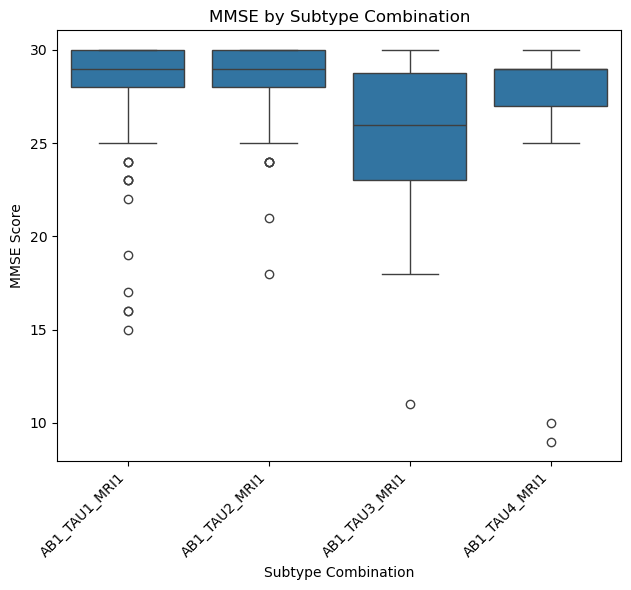


Subtype Combo MMSE Summary:
                  n   mean   std  median   min   max
subtype_combo                                      
AB1_TAU1_MRI1  142  28.28  2.83    29.0  15.0  30.0
AB1_TAU2_MRI1  100  28.45  2.05    29.0  18.0  30.0
AB1_TAU3_MRI1   30  25.00  4.49    26.0  11.0  30.0
AB1_TAU4_MRI1   13  25.46  7.24    29.0   9.0  30.0


In [13]:
# Clean MMSE > 0
multi_clean = final_combined_df[final_combined_df[mmse_score] > 0].copy()

# Keep only subtype combinations with >9 subjects
combo_counts = multi_clean['subtype_combo'].value_counts()
valid_combos = combo_counts[combo_counts > 9].index.tolist()
multi_clean = multi_clean[multi_clean['subtype_combo'].isin(valid_combos)]

# Plot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(data=multi_clean, x='subtype_combo', y=mmse_score)
plt.title('MMSE by Subtype Combination')
plt.xlabel('Subtype Combination')
plt.ylabel('MMSE Score')
plt.xticks(rotation=45, ha='right')  # angled labels for readability

plt.tight_layout()
plt.show()

# Summary stats
mmse_multi_summary = stats(multi_clean, 'subtype_combo', mmse_score)
print("\nSubtype Combo MMSE Summary:\n", mmse_multi_summary)


AB | Frontal_lobe_Asymmetry_ab_L | Combo AB1_TAU1_MRI1 | Slope=-0.001, r=-0.34, p=0.3120
AB | Frontal_lobe_Asymmetry_ab_L | Combo AB1_TAU2_MRI1 | Slope=-0.003, r=-0.39, p=0.2405
AB | Frontal_lobe_Asymmetry_ab_L | Combo AB1_TAU3_MRI1 | Slope=-0.000, r=-0.07, p=0.8398
AB | Frontal_lobe_Asymmetry_ab_L | Combo AB1_TAU4_MRI1 | Slope=0.000, r=0.15, p=0.7541


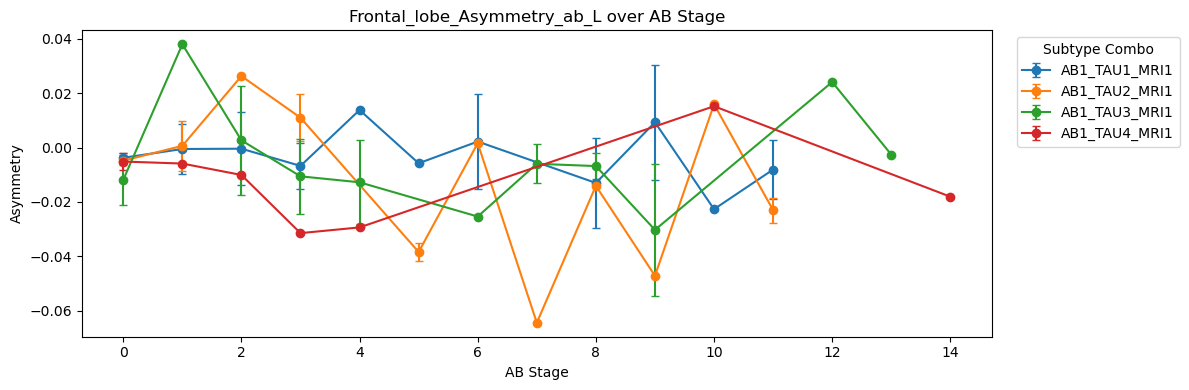

AB | Frontal_lobe_Asymmetry_ab_R | Combo AB1_TAU1_MRI1 | Slope=0.001, r=0.34, p=0.3120
AB | Frontal_lobe_Asymmetry_ab_R | Combo AB1_TAU2_MRI1 | Slope=0.003, r=0.39, p=0.2405
AB | Frontal_lobe_Asymmetry_ab_R | Combo AB1_TAU3_MRI1 | Slope=0.000, r=0.07, p=0.8398
AB | Frontal_lobe_Asymmetry_ab_R | Combo AB1_TAU4_MRI1 | Slope=-0.000, r=-0.15, p=0.7541


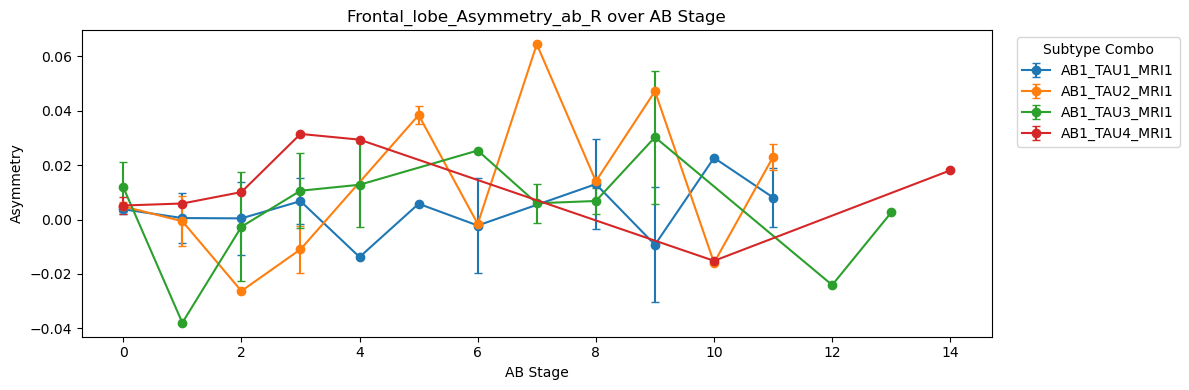

AB | Occipital_lobe_Asymmetry_ab_L | Combo AB1_TAU1_MRI1 | Slope=-0.001, r=-0.07, p=0.8319
AB | Occipital_lobe_Asymmetry_ab_L | Combo AB1_TAU2_MRI1 | Slope=-0.009, r=-0.67, p=0.0228
AB | Occipital_lobe_Asymmetry_ab_L | Combo AB1_TAU3_MRI1 | Slope=0.005, r=0.66, p=0.0271
AB | Occipital_lobe_Asymmetry_ab_L | Combo AB1_TAU4_MRI1 | Slope=0.001, r=0.16, p=0.7278


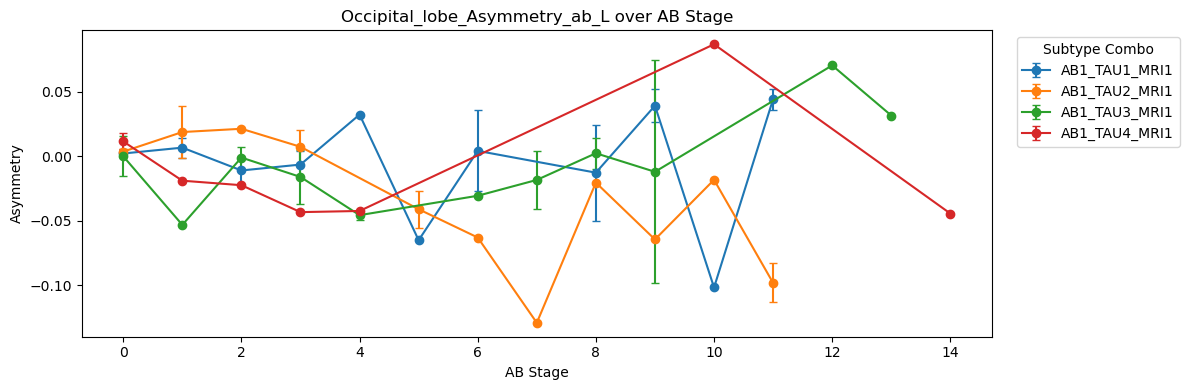

AB | Occipital_lobe_Asymmetry_ab_R | Combo AB1_TAU1_MRI1 | Slope=0.001, r=0.07, p=0.8319
AB | Occipital_lobe_Asymmetry_ab_R | Combo AB1_TAU2_MRI1 | Slope=0.009, r=0.67, p=0.0228
AB | Occipital_lobe_Asymmetry_ab_R | Combo AB1_TAU3_MRI1 | Slope=-0.005, r=-0.66, p=0.0271
AB | Occipital_lobe_Asymmetry_ab_R | Combo AB1_TAU4_MRI1 | Slope=-0.001, r=-0.16, p=0.7278


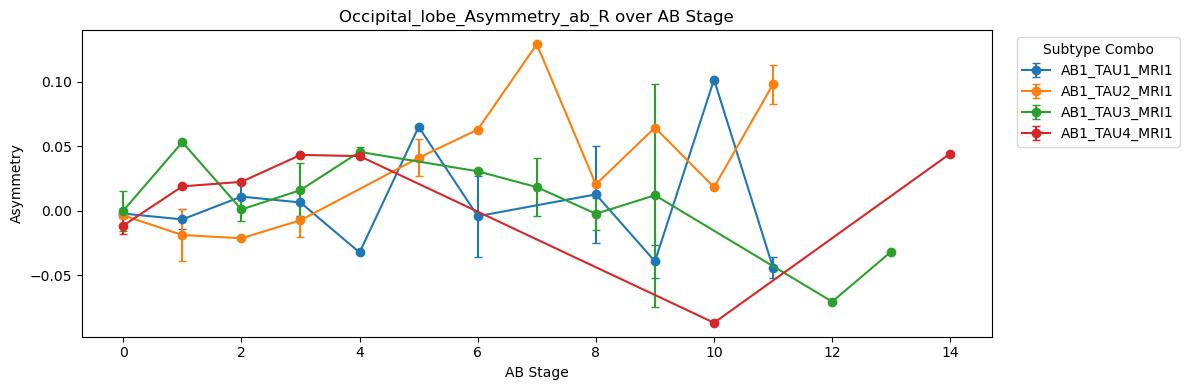

AB | Parietal_lobe_Asymmetry_ab_L | Combo AB1_TAU1_MRI1 | Slope=-0.001, r=-0.20, p=0.5473
AB | Parietal_lobe_Asymmetry_ab_L | Combo AB1_TAU2_MRI1 | Slope=-0.005, r=-0.42, p=0.1936
AB | Parietal_lobe_Asymmetry_ab_L | Combo AB1_TAU3_MRI1 | Slope=0.000, r=0.08, p=0.8094
AB | Parietal_lobe_Asymmetry_ab_L | Combo AB1_TAU4_MRI1 | Slope=0.002, r=0.37, p=0.4193


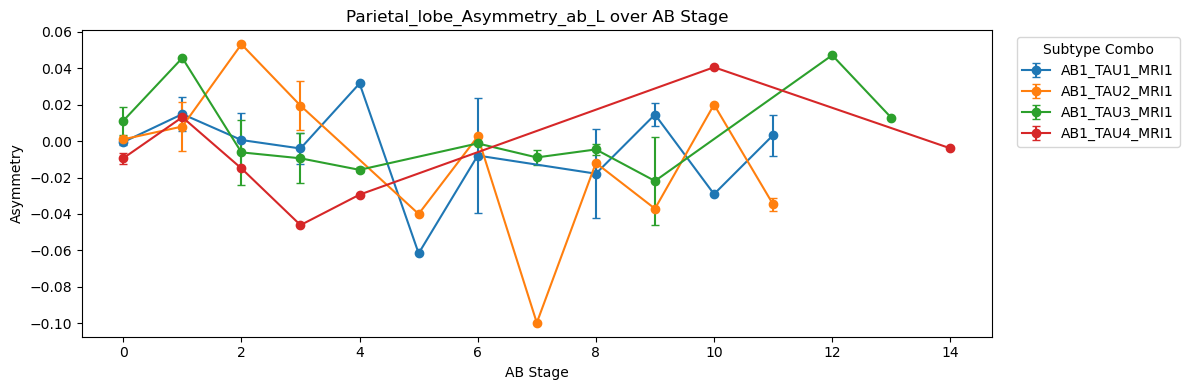

AB | Parietal_lobe_Asymmetry_ab_R | Combo AB1_TAU1_MRI1 | Slope=0.001, r=0.20, p=0.5473
AB | Parietal_lobe_Asymmetry_ab_R | Combo AB1_TAU2_MRI1 | Slope=0.005, r=0.42, p=0.1936
AB | Parietal_lobe_Asymmetry_ab_R | Combo AB1_TAU3_MRI1 | Slope=-0.000, r=-0.08, p=0.8094
AB | Parietal_lobe_Asymmetry_ab_R | Combo AB1_TAU4_MRI1 | Slope=-0.002, r=-0.37, p=0.4193


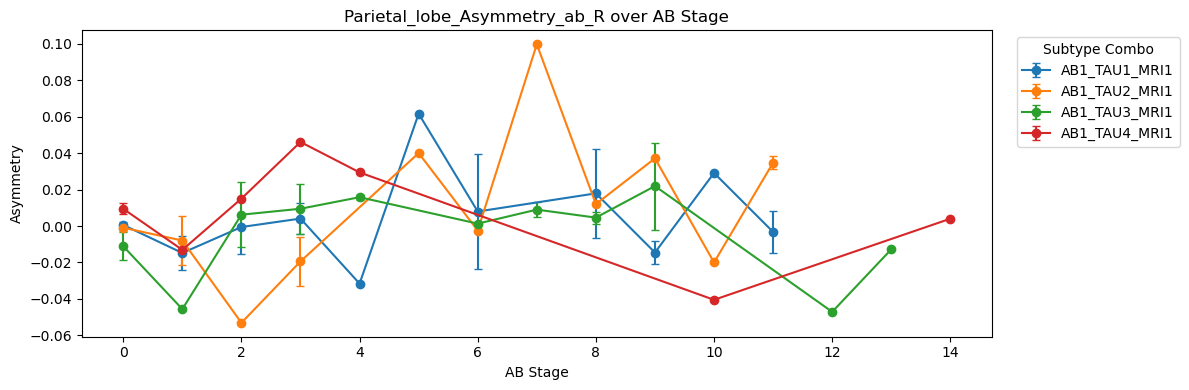

AB | Temporal_lobe_Asymmetry_ab_L | Combo AB1_TAU1_MRI1 | Slope=-0.001, r=-0.11, p=0.7515
AB | Temporal_lobe_Asymmetry_ab_L | Combo AB1_TAU2_MRI1 | Slope=-0.006, r=-0.44, p=0.1790
AB | Temporal_lobe_Asymmetry_ab_L | Combo AB1_TAU3_MRI1 | Slope=0.002, r=0.29, p=0.3906
AB | Temporal_lobe_Asymmetry_ab_L | Combo AB1_TAU4_MRI1 | Slope=0.001, r=0.22, p=0.6390


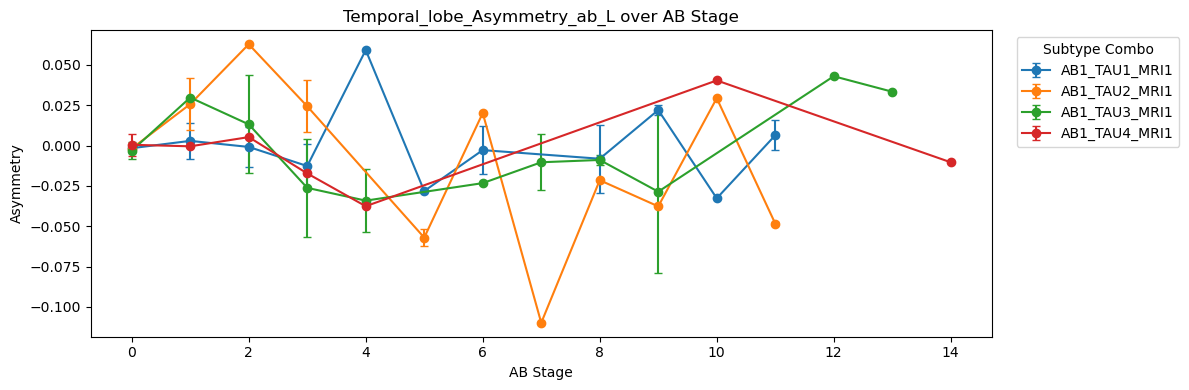

AB | Temporal_lobe_Asymmetry_ab_R | Combo AB1_TAU1_MRI1 | Slope=0.001, r=0.11, p=0.7515
AB | Temporal_lobe_Asymmetry_ab_R | Combo AB1_TAU2_MRI1 | Slope=0.006, r=0.44, p=0.1790
AB | Temporal_lobe_Asymmetry_ab_R | Combo AB1_TAU3_MRI1 | Slope=-0.002, r=-0.29, p=0.3906
AB | Temporal_lobe_Asymmetry_ab_R | Combo AB1_TAU4_MRI1 | Slope=-0.001, r=-0.22, p=0.6390


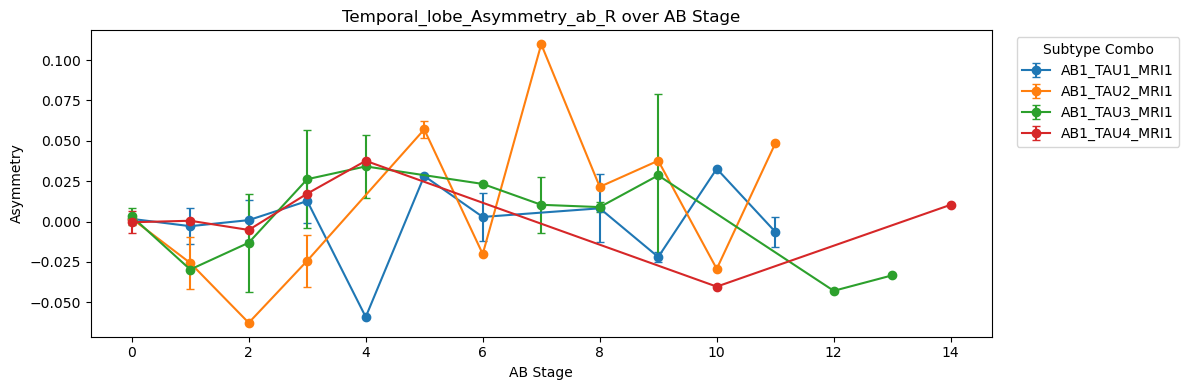

AB | MTL_Asymmetry_ab_L | Combo AB1_TAU1_MRI1 | Slope=-0.001, r=-0.10, p=0.7766
AB | MTL_Asymmetry_ab_L | Combo AB1_TAU2_MRI1 | Slope=-0.004, r=-0.43, p=0.1916
AB | MTL_Asymmetry_ab_L | Combo AB1_TAU3_MRI1 | Slope=-0.001, r=-0.38, p=0.2485
AB | MTL_Asymmetry_ab_L | Combo AB1_TAU4_MRI1 | Slope=0.002, r=0.57, p=0.1838


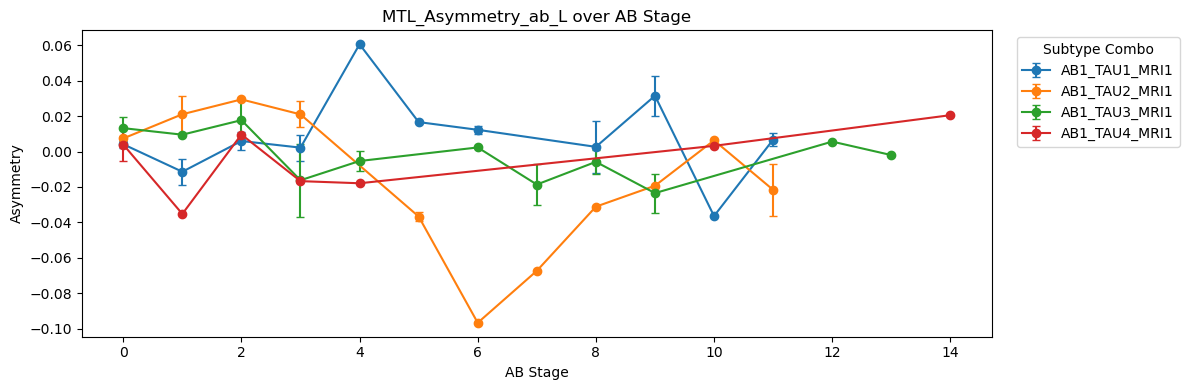

AB | MTL_Asymmetry_ab_R | Combo AB1_TAU1_MRI1 | Slope=0.001, r=0.10, p=0.7766
AB | MTL_Asymmetry_ab_R | Combo AB1_TAU2_MRI1 | Slope=0.004, r=0.43, p=0.1916
AB | MTL_Asymmetry_ab_R | Combo AB1_TAU3_MRI1 | Slope=0.001, r=0.38, p=0.2485
AB | MTL_Asymmetry_ab_R | Combo AB1_TAU4_MRI1 | Slope=-0.002, r=-0.57, p=0.1838


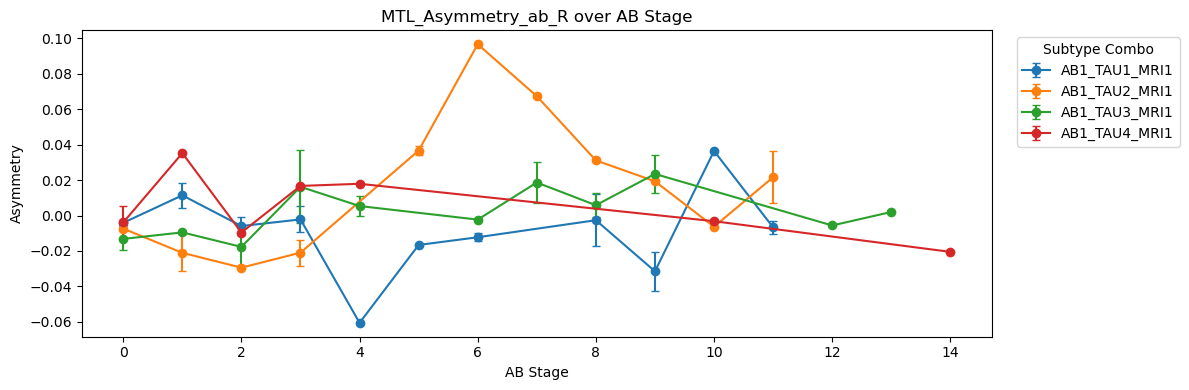

TAU | Frontal_lobe_Asymmetry_tau_L | Combo AB1_TAU1_MRI1 | Slope=0.009, r=0.65, p=0.1587
TAU | Frontal_lobe_Asymmetry_tau_L | Combo AB1_TAU2_MRI1 | Slope=-0.004, r=-0.73, p=0.4809
TAU | Frontal_lobe_Asymmetry_tau_L | Combo AB1_TAU3_MRI1 | Slope=-0.003, r=-0.54, p=0.1041
TAU | Frontal_lobe_Asymmetry_tau_L | Combo AB1_TAU4_MRI1 | Slope=-0.001, r=-0.09, p=0.8803


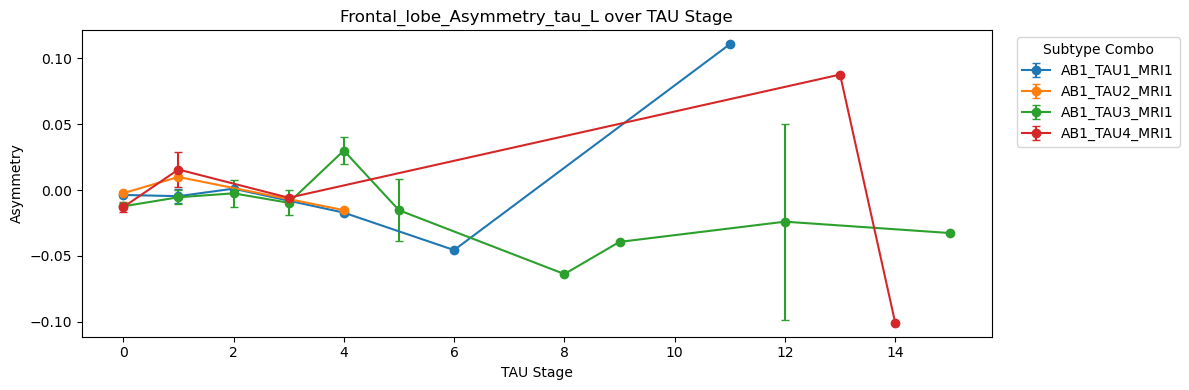

TAU | Frontal_lobe_Asymmetry_tau_R | Combo AB1_TAU1_MRI1 | Slope=-0.009, r=-0.65, p=0.1587
TAU | Frontal_lobe_Asymmetry_tau_R | Combo AB1_TAU2_MRI1 | Slope=0.004, r=0.73, p=0.4809
TAU | Frontal_lobe_Asymmetry_tau_R | Combo AB1_TAU3_MRI1 | Slope=0.003, r=0.54, p=0.1041
TAU | Frontal_lobe_Asymmetry_tau_R | Combo AB1_TAU4_MRI1 | Slope=0.001, r=0.09, p=0.8803


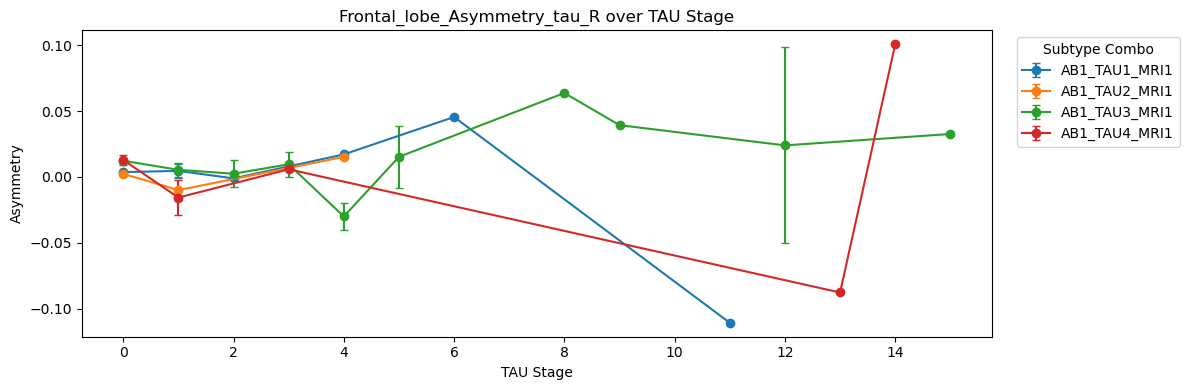

TAU | Occipital_lobe_Asymmetry_tau_L | Combo AB1_TAU1_MRI1 | Slope=0.022, r=0.78, p=0.0692
TAU | Occipital_lobe_Asymmetry_tau_L | Combo AB1_TAU2_MRI1 | Slope=-0.048, r=-0.99, p=0.1009
TAU | Occipital_lobe_Asymmetry_tau_L | Combo AB1_TAU3_MRI1 | Slope=-0.001, r=-0.06, p=0.8723
TAU | Occipital_lobe_Asymmetry_tau_L | Combo AB1_TAU4_MRI1 | Slope=-0.007, r=-0.45, p=0.4423


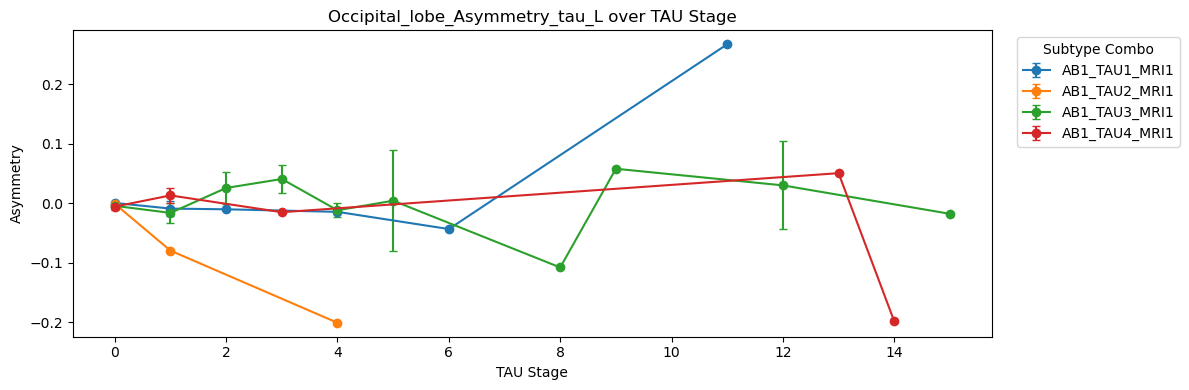

TAU | Occipital_lobe_Asymmetry_tau_R | Combo AB1_TAU1_MRI1 | Slope=-0.022, r=-0.78, p=0.0692
TAU | Occipital_lobe_Asymmetry_tau_R | Combo AB1_TAU2_MRI1 | Slope=0.048, r=0.99, p=0.1009
TAU | Occipital_lobe_Asymmetry_tau_R | Combo AB1_TAU3_MRI1 | Slope=0.001, r=0.06, p=0.8723
TAU | Occipital_lobe_Asymmetry_tau_R | Combo AB1_TAU4_MRI1 | Slope=0.007, r=0.45, p=0.4423


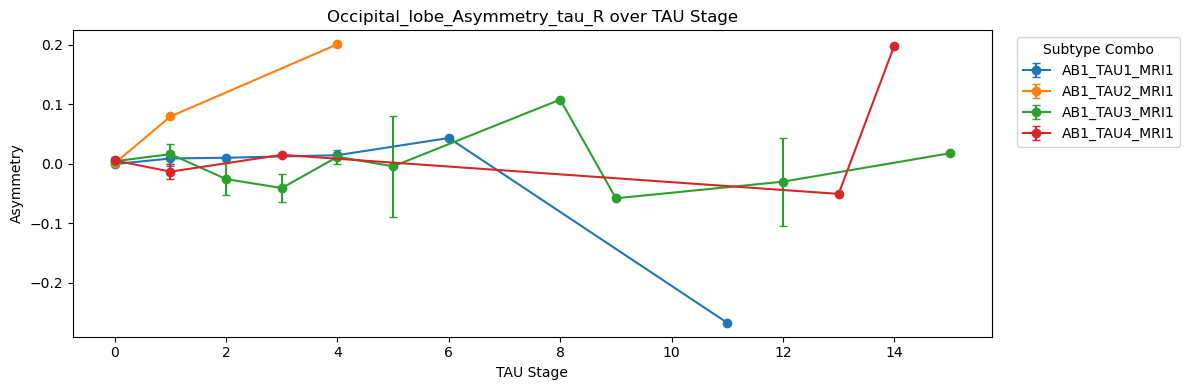

TAU | Parietal_lobe_Asymmetry_tau_L | Combo AB1_TAU1_MRI1 | Slope=0.013, r=0.54, p=0.2723
TAU | Parietal_lobe_Asymmetry_tau_L | Combo AB1_TAU2_MRI1 | Slope=-0.021, r=-0.95, p=0.2109
TAU | Parietal_lobe_Asymmetry_tau_L | Combo AB1_TAU3_MRI1 | Slope=-0.001, r=-0.17, p=0.6465
TAU | Parietal_lobe_Asymmetry_tau_L | Combo AB1_TAU4_MRI1 | Slope=0.003, r=0.20, p=0.7433


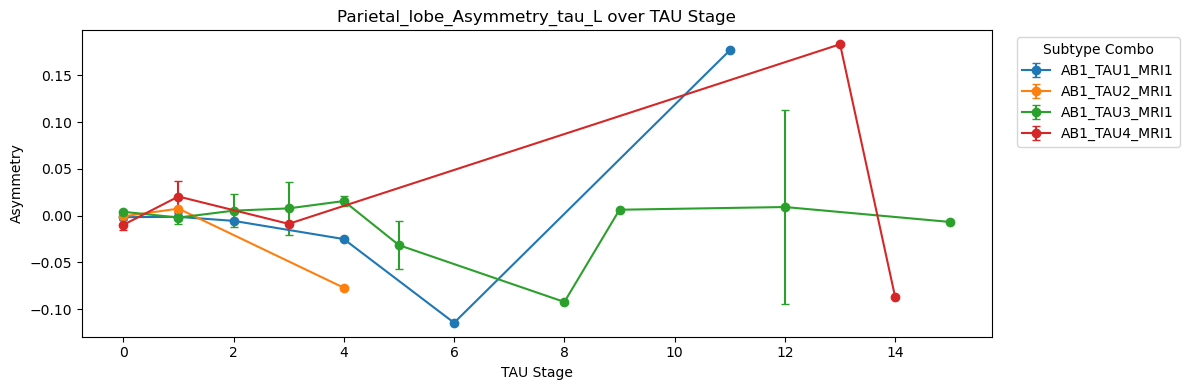

TAU | Parietal_lobe_Asymmetry_tau_R | Combo AB1_TAU1_MRI1 | Slope=-0.013, r=-0.54, p=0.2723
TAU | Parietal_lobe_Asymmetry_tau_R | Combo AB1_TAU2_MRI1 | Slope=0.021, r=0.95, p=0.2109
TAU | Parietal_lobe_Asymmetry_tau_R | Combo AB1_TAU3_MRI1 | Slope=0.001, r=0.17, p=0.6465
TAU | Parietal_lobe_Asymmetry_tau_R | Combo AB1_TAU4_MRI1 | Slope=-0.003, r=-0.20, p=0.7433


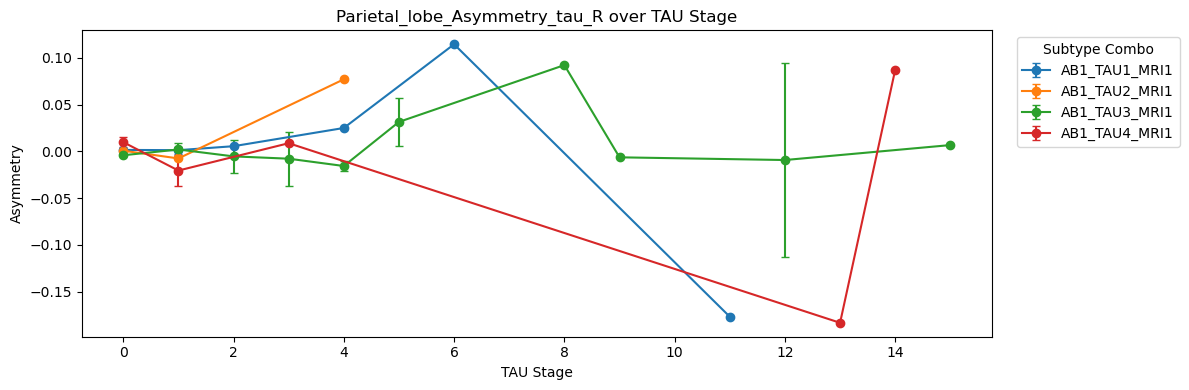

TAU | Temporal_lobe_Asymmetry_tau_L | Combo AB1_TAU1_MRI1 | Slope=0.008, r=0.37, p=0.4764
TAU | Temporal_lobe_Asymmetry_tau_L | Combo AB1_TAU2_MRI1 | Slope=-0.030, r=-0.90, p=0.2927
TAU | Temporal_lobe_Asymmetry_tau_L | Combo AB1_TAU3_MRI1 | Slope=-0.003, r=-0.38, p=0.2820
TAU | Temporal_lobe_Asymmetry_tau_L | Combo AB1_TAU4_MRI1 | Slope=-0.003, r=-0.36, p=0.5503


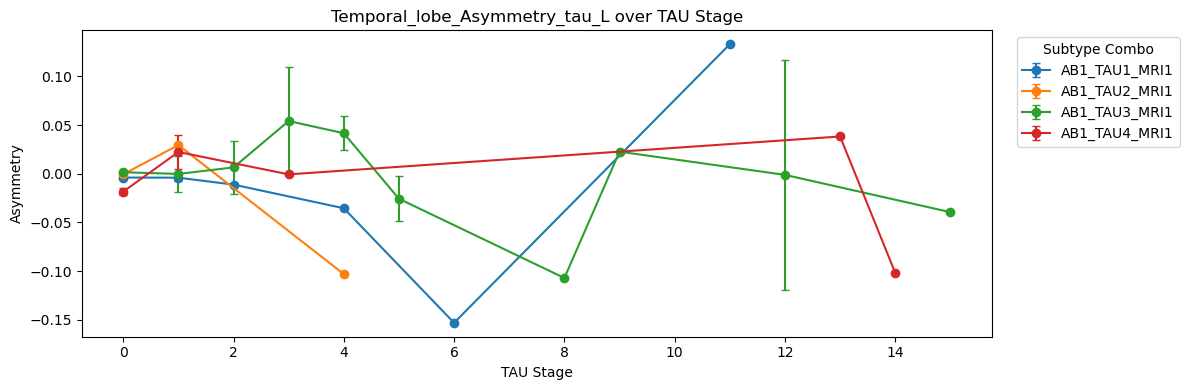

TAU | Temporal_lobe_Asymmetry_tau_R | Combo AB1_TAU1_MRI1 | Slope=-0.008, r=-0.37, p=0.4764
TAU | Temporal_lobe_Asymmetry_tau_R | Combo AB1_TAU2_MRI1 | Slope=0.030, r=0.90, p=0.2927
TAU | Temporal_lobe_Asymmetry_tau_R | Combo AB1_TAU3_MRI1 | Slope=0.003, r=0.38, p=0.2820
TAU | Temporal_lobe_Asymmetry_tau_R | Combo AB1_TAU4_MRI1 | Slope=0.003, r=0.36, p=0.5503


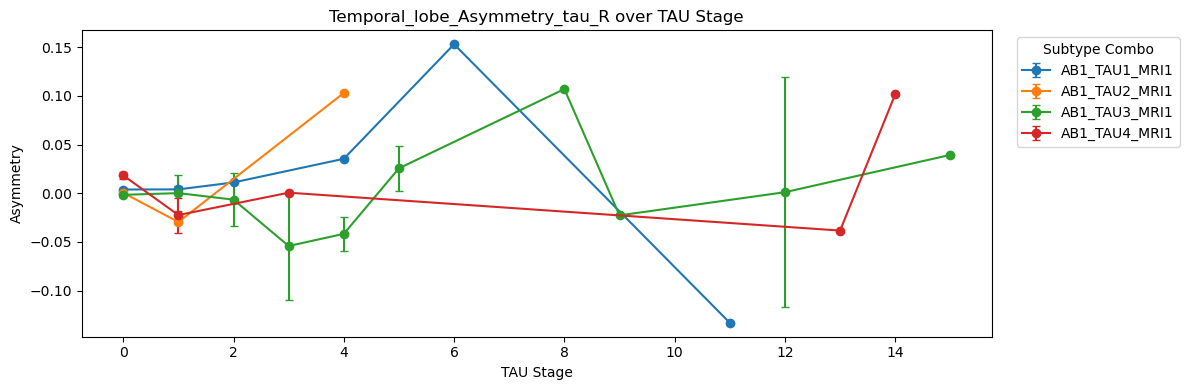

TAU | MTL_Asymmetry_tau_L | Combo AB1_TAU1_MRI1 | Slope=-0.003, r=-0.62, p=0.1864
TAU | MTL_Asymmetry_tau_L | Combo AB1_TAU2_MRI1 | Slope=-0.015, r=-0.81, p=0.3972
TAU | MTL_Asymmetry_tau_L | Combo AB1_TAU3_MRI1 | Slope=0.000, r=0.11, p=0.7707
TAU | MTL_Asymmetry_tau_L | Combo AB1_TAU4_MRI1 | Slope=-0.003, r=-0.85, p=0.0689


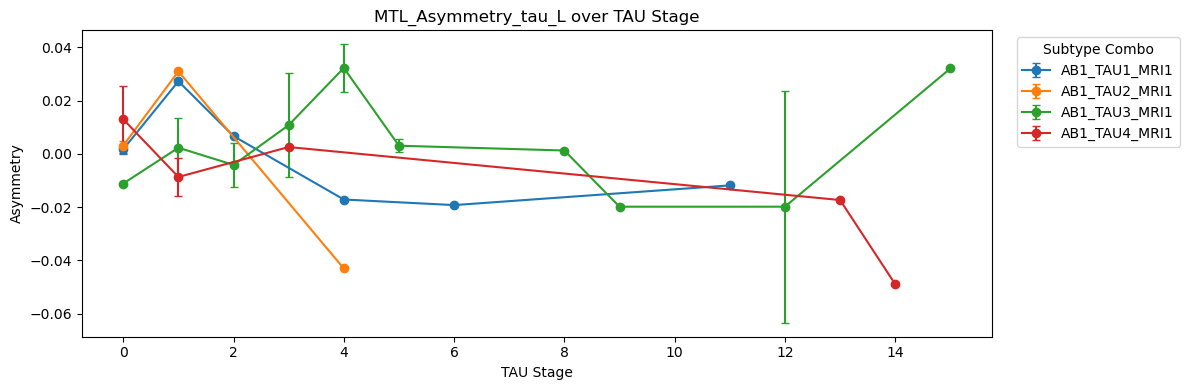

TAU | MTL_Asymmetry_tau_R | Combo AB1_TAU1_MRI1 | Slope=0.003, r=0.62, p=0.1864
TAU | MTL_Asymmetry_tau_R | Combo AB1_TAU2_MRI1 | Slope=0.015, r=0.81, p=0.3972
TAU | MTL_Asymmetry_tau_R | Combo AB1_TAU3_MRI1 | Slope=-0.000, r=-0.11, p=0.7707
TAU | MTL_Asymmetry_tau_R | Combo AB1_TAU4_MRI1 | Slope=0.003, r=0.85, p=0.0689


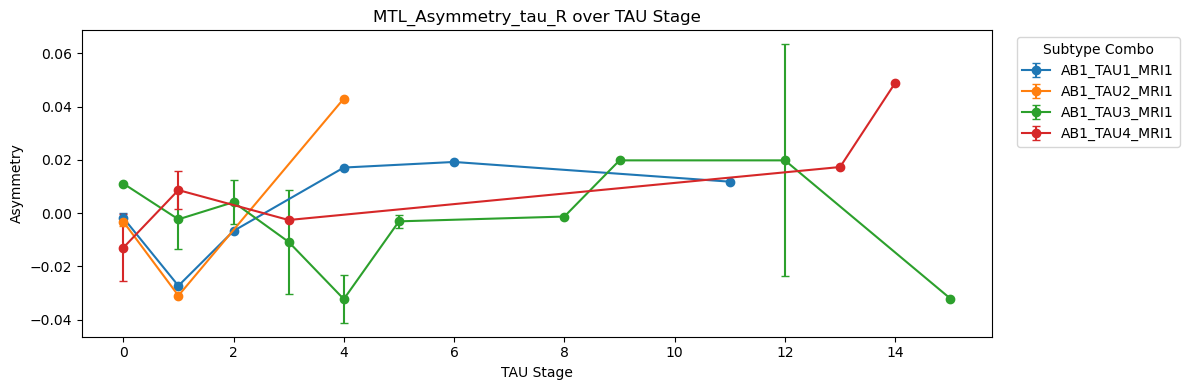

MRI | Frontal_lobe_Asymmetry_MRI_L | Combo AB1_TAU1_MRI1 | Slope=-0.003, r=-0.41, p=0.4987
MRI | Frontal_lobe_Asymmetry_MRI_L | Combo AB1_TAU2_MRI1 | Slope=-0.000, r=-0.04, p=0.9456
MRI | Frontal_lobe_Asymmetry_MRI_L | Combo AB1_TAU3_MRI1 | Slope=0.000, r=0.11, p=0.8630
MRI | Frontal_lobe_Asymmetry_MRI_L | Combo AB1_TAU4_MRI1 | Slope=-0.002, r=-0.58, p=0.6094


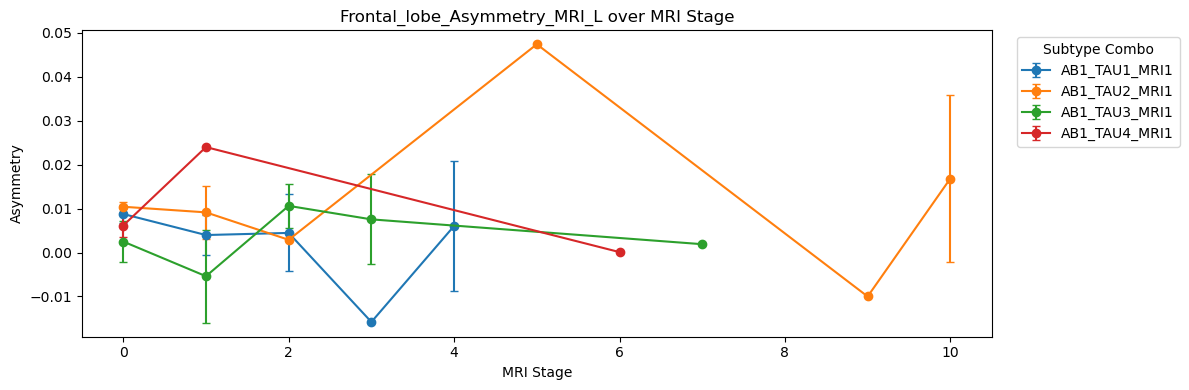

MRI | Frontal_lobe_Asymmetry_MRI_R | Combo AB1_TAU1_MRI1 | Slope=0.003, r=0.41, p=0.4987
MRI | Frontal_lobe_Asymmetry_MRI_R | Combo AB1_TAU2_MRI1 | Slope=0.000, r=0.04, p=0.9456
MRI | Frontal_lobe_Asymmetry_MRI_R | Combo AB1_TAU3_MRI1 | Slope=-0.000, r=-0.11, p=0.8630
MRI | Frontal_lobe_Asymmetry_MRI_R | Combo AB1_TAU4_MRI1 | Slope=0.002, r=0.58, p=0.6094


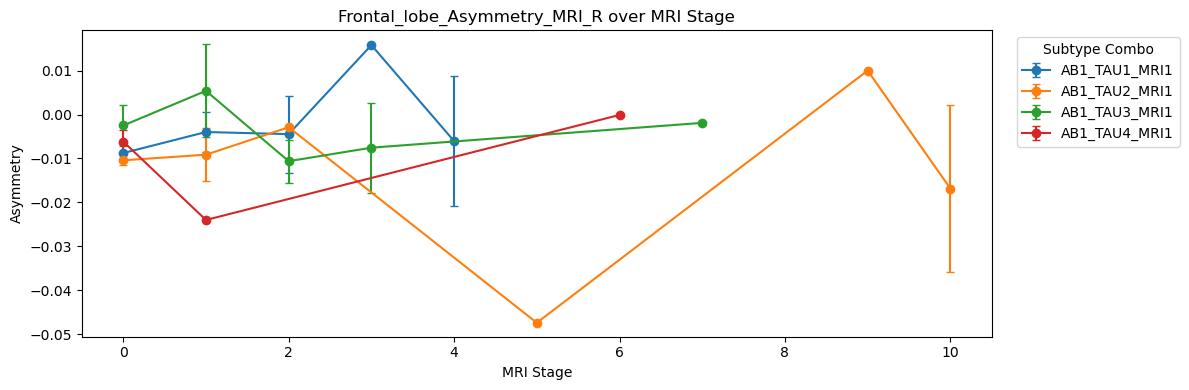

MRI | Occipital_lobe_Asymmetry_MRI_L | Combo AB1_TAU1_MRI1 | Slope=-0.015, r=-0.90, p=0.0383
MRI | Occipital_lobe_Asymmetry_MRI_L | Combo AB1_TAU2_MRI1 | Slope=-0.001, r=-0.12, p=0.8161
MRI | Occipital_lobe_Asymmetry_MRI_L | Combo AB1_TAU3_MRI1 | Slope=0.000, r=0.00, p=0.9970
MRI | Occipital_lobe_Asymmetry_MRI_L | Combo AB1_TAU4_MRI1 | Slope=-0.017, r=-0.75, p=0.4584


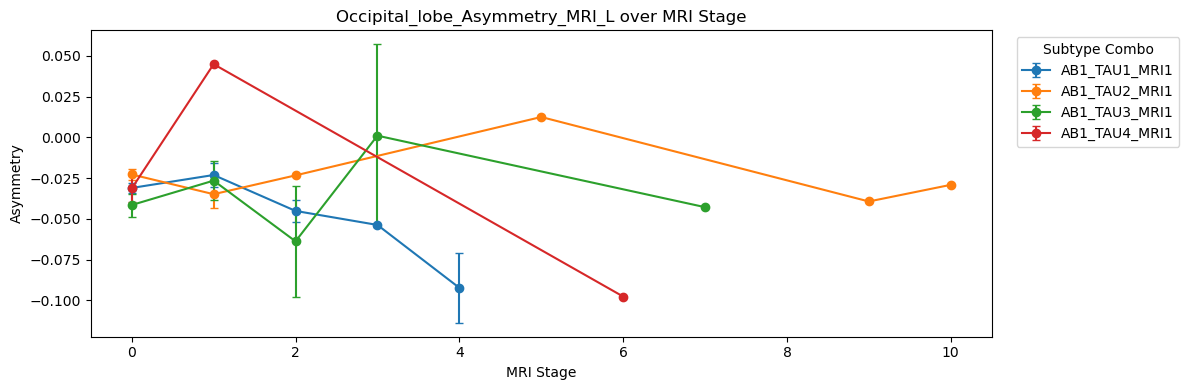

MRI | Occipital_lobe_Asymmetry_MRI_R | Combo AB1_TAU1_MRI1 | Slope=0.015, r=0.90, p=0.0383
MRI | Occipital_lobe_Asymmetry_MRI_R | Combo AB1_TAU2_MRI1 | Slope=0.001, r=0.12, p=0.8161
MRI | Occipital_lobe_Asymmetry_MRI_R | Combo AB1_TAU3_MRI1 | Slope=-0.000, r=-0.00, p=0.9970
MRI | Occipital_lobe_Asymmetry_MRI_R | Combo AB1_TAU4_MRI1 | Slope=0.017, r=0.75, p=0.4584


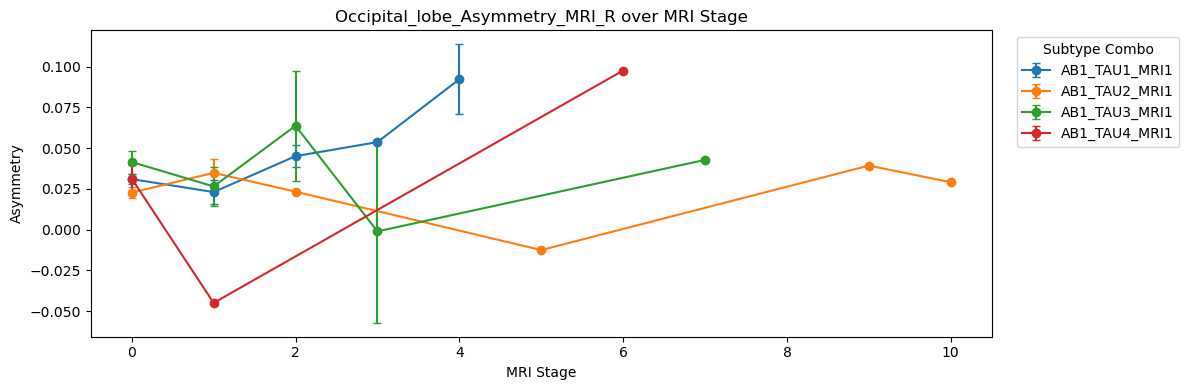

MRI | Parietal_lobe_Asymmetry_MRI_L | Combo AB1_TAU1_MRI1 | Slope=-0.006, r=-0.81, p=0.0963
MRI | Parietal_lobe_Asymmetry_MRI_L | Combo AB1_TAU2_MRI1 | Slope=-0.002, r=-0.50, p=0.3139
MRI | Parietal_lobe_Asymmetry_MRI_L | Combo AB1_TAU3_MRI1 | Slope=-0.001, r=-0.38, p=0.5333
MRI | Parietal_lobe_Asymmetry_MRI_L | Combo AB1_TAU4_MRI1 | Slope=-0.006, r=-0.78, p=0.4291


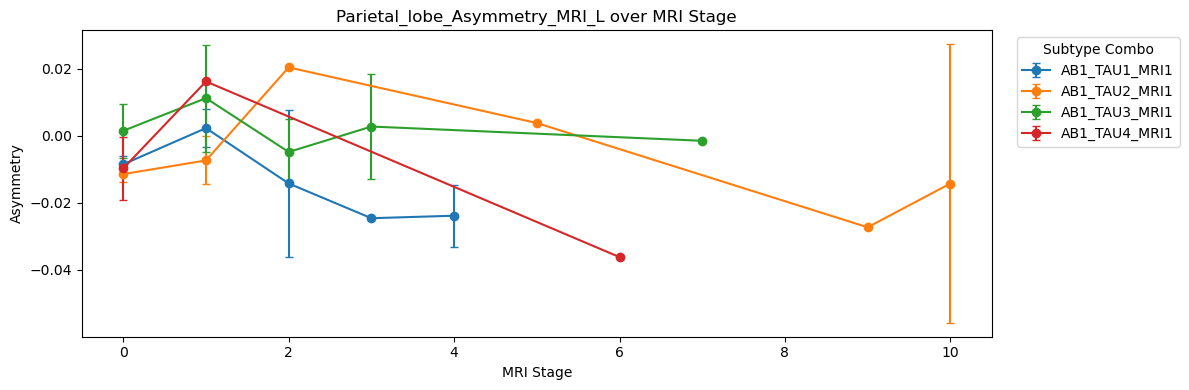

MRI | Parietal_lobe_Asymmetry_MRI_R | Combo AB1_TAU1_MRI1 | Slope=0.006, r=0.81, p=0.0963
MRI | Parietal_lobe_Asymmetry_MRI_R | Combo AB1_TAU2_MRI1 | Slope=0.002, r=0.50, p=0.3139
MRI | Parietal_lobe_Asymmetry_MRI_R | Combo AB1_TAU3_MRI1 | Slope=0.001, r=0.38, p=0.5333
MRI | Parietal_lobe_Asymmetry_MRI_R | Combo AB1_TAU4_MRI1 | Slope=0.006, r=0.78, p=0.4291


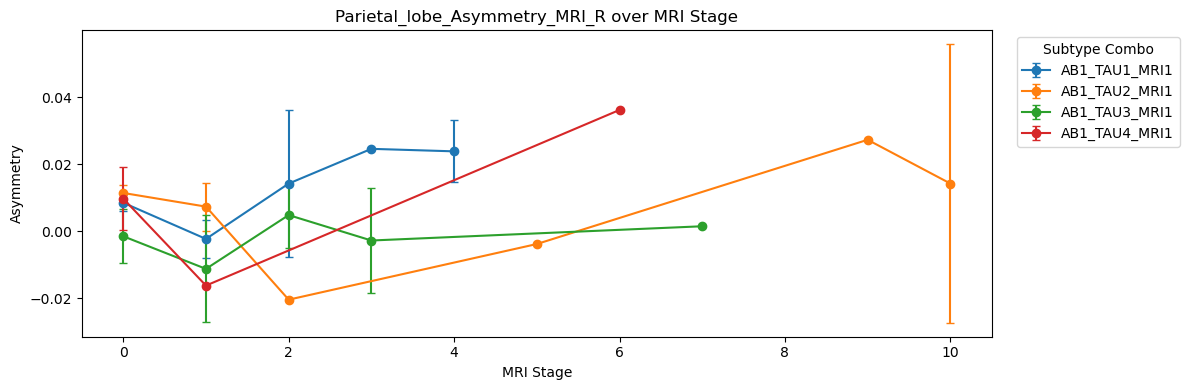

MRI | Temporal_lobe_Asymmetry_MRI_L | Combo AB1_TAU1_MRI1 | Slope=-0.023, r=-0.82, p=0.0878
MRI | Temporal_lobe_Asymmetry_MRI_L | Combo AB1_TAU2_MRI1 | Slope=0.003, r=0.21, p=0.6839
MRI | Temporal_lobe_Asymmetry_MRI_L | Combo AB1_TAU3_MRI1 | Slope=0.002, r=0.86, p=0.0613
MRI | Temporal_lobe_Asymmetry_MRI_L | Combo AB1_TAU4_MRI1 | Slope=-0.026, r=-0.82, p=0.3913


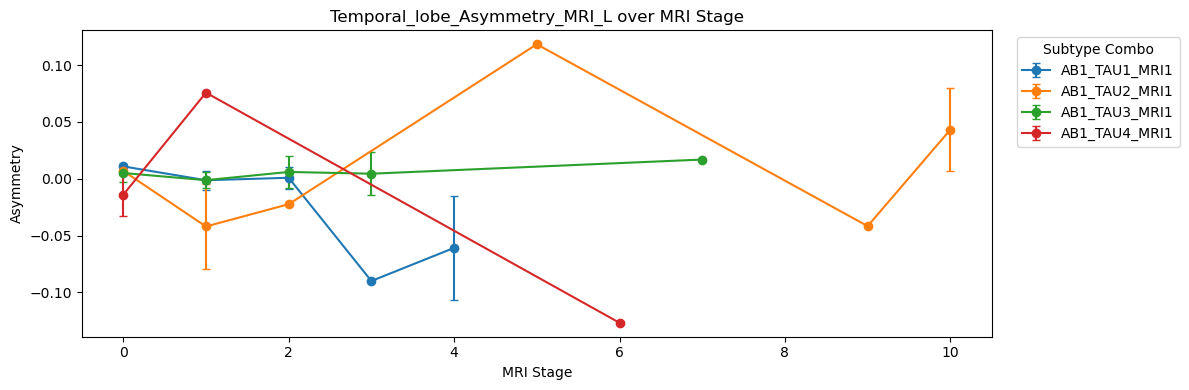

MRI | Temporal_lobe_Asymmetry_MRI_R | Combo AB1_TAU1_MRI1 | Slope=0.023, r=0.82, p=0.0878
MRI | Temporal_lobe_Asymmetry_MRI_R | Combo AB1_TAU2_MRI1 | Slope=-0.003, r=-0.21, p=0.6839
MRI | Temporal_lobe_Asymmetry_MRI_R | Combo AB1_TAU3_MRI1 | Slope=-0.002, r=-0.86, p=0.0613
MRI | Temporal_lobe_Asymmetry_MRI_R | Combo AB1_TAU4_MRI1 | Slope=0.026, r=0.82, p=0.3913


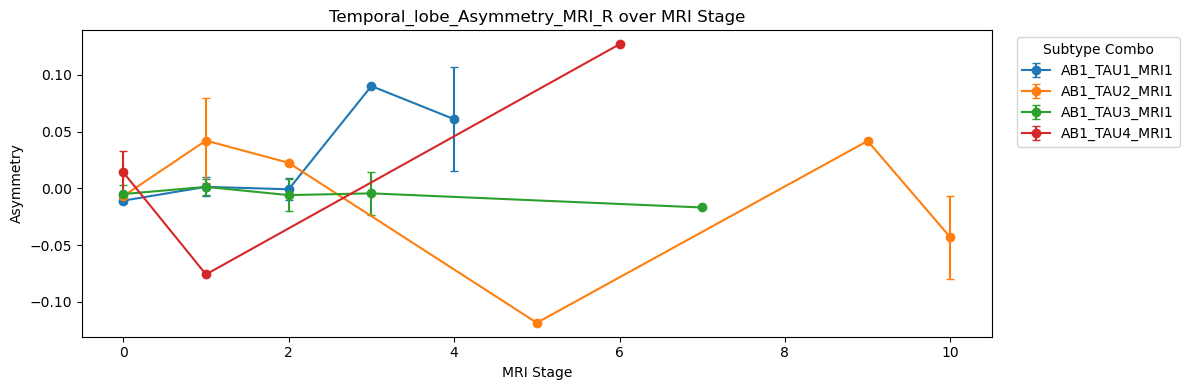

MRI | MTL_Asymmetry_MRI_L | Combo AB1_TAU1_MRI1 | Slope=-0.016, r=-0.84, p=0.0770
MRI | MTL_Asymmetry_MRI_L | Combo AB1_TAU2_MRI1 | Slope=0.006, r=0.30, p=0.5655
MRI | MTL_Asymmetry_MRI_L | Combo AB1_TAU3_MRI1 | Slope=-0.013, r=-0.76, p=0.1353
MRI | MTL_Asymmetry_MRI_L | Combo AB1_TAU4_MRI1 | Slope=0.003, r=0.13, p=0.9177


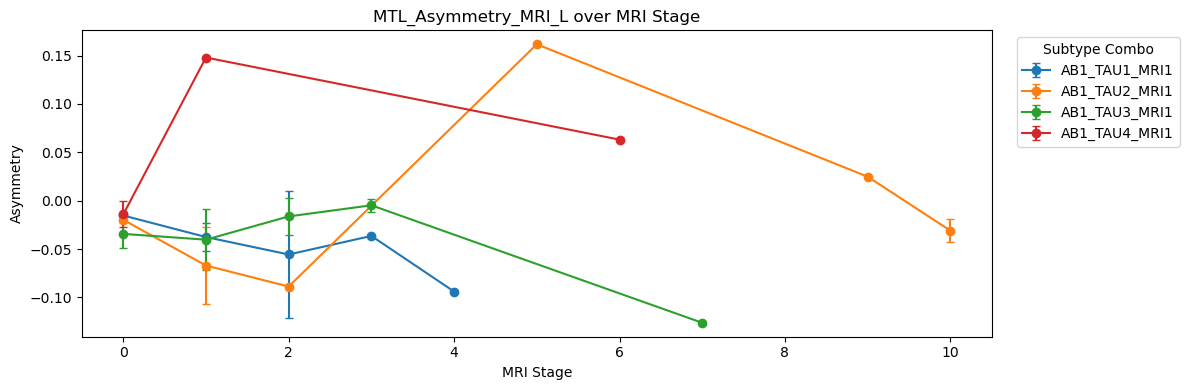

MRI | MTL_Asymmetry_MRI_R | Combo AB1_TAU1_MRI1 | Slope=0.016, r=0.84, p=0.0770
MRI | MTL_Asymmetry_MRI_R | Combo AB1_TAU2_MRI1 | Slope=-0.006, r=-0.30, p=0.5655
MRI | MTL_Asymmetry_MRI_R | Combo AB1_TAU3_MRI1 | Slope=0.013, r=0.76, p=0.1353
MRI | MTL_Asymmetry_MRI_R | Combo AB1_TAU4_MRI1 | Slope=-0.003, r=-0.13, p=0.9177


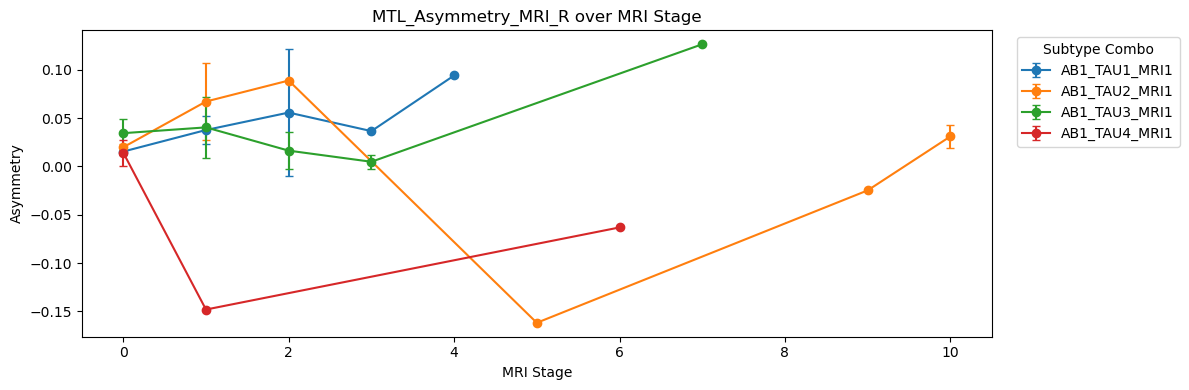


====== Statistically Significant Asymmetry Findings (p < 0.05) ======
  Modality                          Region  Subtype_Combo     Slope         r  \
0       AB   Occipital_lobe_Asymmetry_ab_L  AB1_TAU2_MRI1 -0.008894 -0.674520   
2       AB   Occipital_lobe_Asymmetry_ab_R  AB1_TAU2_MRI1  0.008894  0.674520   
1       AB   Occipital_lobe_Asymmetry_ab_L  AB1_TAU3_MRI1  0.005285  0.660073   
3       AB   Occipital_lobe_Asymmetry_ab_R  AB1_TAU3_MRI1 -0.005285 -0.660073   
4      MRI  Occipital_lobe_Asymmetry_MRI_L  AB1_TAU1_MRI1 -0.015310 -0.898447   
5      MRI  Occipital_lobe_Asymmetry_MRI_R  AB1_TAU1_MRI1  0.015310  0.898447   

          p  
0  0.022810  
2  0.022810  
1  0.027088  
3  0.027088  
4  0.038251  
5  0.038251  


In [14]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd

asymmetry_vars = {
    'AB': [
        'Frontal_lobe_Asymmetry_ab_L', 'Frontal_lobe_Asymmetry_ab_R',
        'Occipital_lobe_Asymmetry_ab_L', 'Occipital_lobe_Asymmetry_ab_R',
        'Parietal_lobe_Asymmetry_ab_L', 'Parietal_lobe_Asymmetry_ab_R',
        'Temporal_lobe_Asymmetry_ab_L', 'Temporal_lobe_Asymmetry_ab_R',
        'MTL_Asymmetry_ab_L', 'MTL_Asymmetry_ab_R',
    ],
    'TAU': [
        'Frontal_lobe_Asymmetry_tau_L', 'Frontal_lobe_Asymmetry_tau_R',
        'Occipital_lobe_Asymmetry_tau_L', 'Occipital_lobe_Asymmetry_tau_R',
        'Parietal_lobe_Asymmetry_tau_L', 'Parietal_lobe_Asymmetry_tau_R',
        'Temporal_lobe_Asymmetry_tau_L', 'Temporal_lobe_Asymmetry_tau_R',
        'MTL_Asymmetry_tau_L', 'MTL_Asymmetry_tau_R',
    ],
    'MRI': [
        'Frontal_lobe_Asymmetry_MRI_L', 'Frontal_lobe_Asymmetry_MRI_R',
        'Occipital_lobe_Asymmetry_MRI_L', 'Occipital_lobe_Asymmetry_MRI_R',
        'Parietal_lobe_Asymmetry_MRI_L', 'Parietal_lobe_Asymmetry_MRI_R',
        'Temporal_lobe_Asymmetry_MRI_L', 'Temporal_lobe_Asymmetry_MRI_R',
        'MTL_Asymmetry_MRI_L', 'MTL_Asymmetry_MRI_R',
    ]
}

modality_stage_cols = {
    'AB': 'ab_ml_stage',
    'TAU': 'tau_ml_stage',
    'MRI': 'mri_ml_stage'
}

modality_subtype_cols = {
    'AB': 'ab_ml_subtype',
    'TAU': 'tau_ml_subtype',
    'MRI': 'mri_ml_subtype'
}

combo_col = 'subtype_combo'
triplet_counts = final_combined_df[combo_col].value_counts()
valid_combos = triplet_counts[triplet_counts >= 10].index.tolist()

significant_results = []

for modality, asym_vars in asymmetry_vars.items():
    stage_col = modality_stage_cols[modality]
    subtype_col = modality_subtype_cols[modality]

    for region in asym_vars:
        if region not in final_combined_df.columns:
            continue

        plt.figure(figsize=(12, 4))

        for subtype_combo in sorted(valid_combos):
            sub_df = final_combined_df[
                (final_combined_df[combo_col] == subtype_combo) &
                (final_combined_df[stage_col].notna())
            ]

            grouped = sub_df.groupby(stage_col)[region]
            means = grouped.mean()
            sems = grouped.sem()

            if means.empty:
                continue

            plt.errorbar(means.index, means.values, yerr=sems, label=f'{subtype_combo}',
                         marker='o', capsize=3)

            # Linear regression & print per combo-region-modality
            if len(means) > 1:
                slope, intercept, r, pval, stderr = linregress(means.index, means.values)
                print(f"{modality} | {region} | Combo {subtype_combo} | "
                      f"Slope={slope:.3f}, r={r:.2f}, p={pval:.4f}")

                # Store if significant
                if pval < 0.05:
                    significant_results.append({
                        'Modality': modality,
                        'Region': region,
                        'Subtype_Combo': subtype_combo,
                        'Slope': slope,
                        'r': r,
                        'p': pval
                    })

        plt.title(f"{region} over {modality} Stage")
        plt.xlabel(f"{modality} Stage")
        plt.ylabel("Asymmetry")
        plt.legend(title="Subtype Combo", bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Final summary of all significant findings
sig_df = pd.DataFrame(significant_results)
if not sig_df.empty:
    print("\n====== Statistically Significant Asymmetry Findings (p < 0.05) ======")
    print(sig_df.sort_values(['Modality', 'p']))
else:
    print("\nNo statistically significant asymmetry trends detected (p < 0.05).")


In [15]:
from scipy.stats import ttest_1samp

asym_onsets = []

# Loop through each modality
for modality in ['AB', 'TAU', 'MRI']:
    subtype_col = f'{modality.lower()}_ml_subtype'  # ab_ml_subtype, etc.
    stage_col = f'{modality.lower()}_ml_stage'      # ab_ml_stage, etc.
    asym_vars = asymmetry_vars[modality]

    # Drop rows missing relevant columns
    df_mod = final_combined_df.dropna(subset=[subtype_col, stage_col])

    subtypes = sorted(df_mod[subtype_col].unique())

    for region in asym_vars:
        if region not in df_mod.columns:
            continue

        for subtype in subtypes:
            sub_df = df_mod[df_mod[subtype_col] == subtype]
            grouped = sub_df.groupby(stage_col)[region]

            for stage, values in grouped:
                values = values.dropna()
                if len(values) < 5:
                    continue

                t_stat, p_val = ttest_1samp(values, 0)
                mean_val = values.mean()

                if p_val < 0.05 and abs(mean_val) > 0.05:
                    asym_onsets.append({
                        'Modality': modality,
                        'Region': region,
                        'Subtype': subtype+1,
                        'Stage': stage,
                        'MeanAsym': round(mean_val, 3),
                        'p': round(p_val, 4)
                    })
                    break  # First significant stage = onset

# Format and print results
onset_df = pd.DataFrame(asym_onsets)
onset_df = onset_df.sort_values(by=['Modality', 'Subtype', 'Region', 'Stage'])

print("\n==== Asymmetry Onset by Subtype & Region (first stage with significant asymmetry) ====\n")
print(onset_df)

# Optional summary: earliest stage per region-subtype
early_asym_counts = onset_df.groupby(['Modality', 'Subtype', 'Region'])['Stage'].min().sort_values()
print("\n==== Earliest Significant Asymmetry Stage per Region & Subtype ====\n")
print(early_asym_counts)



==== Asymmetry Onset by Subtype & Region (first stage with significant asymmetry) ====

  Modality                          Region  Subtype  Stage  MeanAsym       p
0      MRI  Occipital_lobe_Asymmetry_MRI_L      1.0    2.0    -0.053  0.0213
1      MRI  Occipital_lobe_Asymmetry_MRI_R      1.0    2.0     0.053  0.0213

==== Earliest Significant Asymmetry Stage per Region & Subtype ====

Modality  Subtype  Region                        
MRI       1.0      Occipital_lobe_Asymmetry_MRI_L    2.0
                   Occipital_lobe_Asymmetry_MRI_R    2.0
Name: Stage, dtype: float64



====== Memory Score Across Stages in AB ======
AB1_TAU1_MRI1 | Slope = -0.078, r = -0.21, p = 0.5279
AB1_TAU2_MRI1 | Slope = -0.351, r = -0.40, p = 0.2266
AB1_TAU3_MRI1 | Slope = 0.109, r = 0.15, p = 0.6684
AB1_TAU4_MRI1 | Slope = 0.277, r = 0.20, p = 0.6616


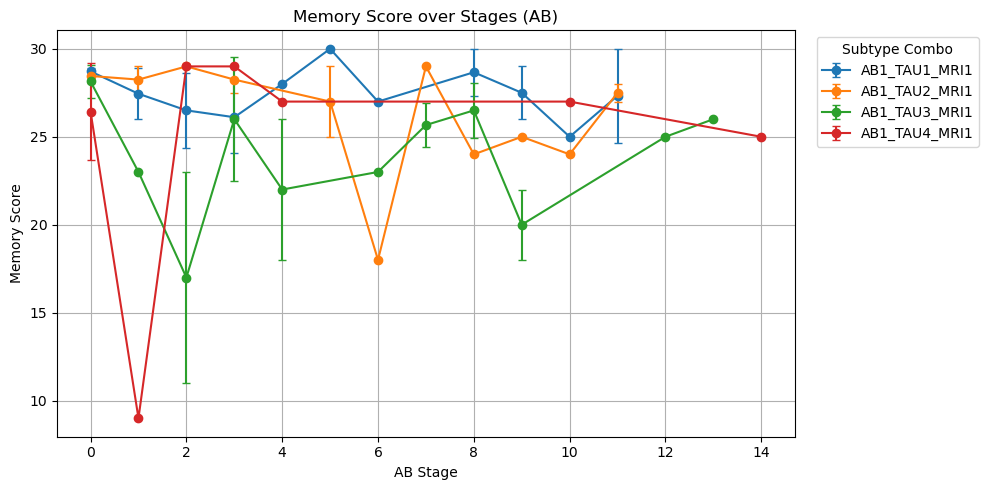


====== Memory Score Across Stages in TAU ======
AB1_TAU1_MRI1 | Slope = -1.032, r = -0.72, p = 0.1036
AB1_TAU2_MRI1 | Slope = 0.267, r = 0.23, p = 0.8496
AB1_TAU3_MRI1 | Slope = -0.682, r = -0.67, p = 0.0350
AB1_TAU4_MRI1 | Slope = -0.747, r = -0.64, p = 0.2410


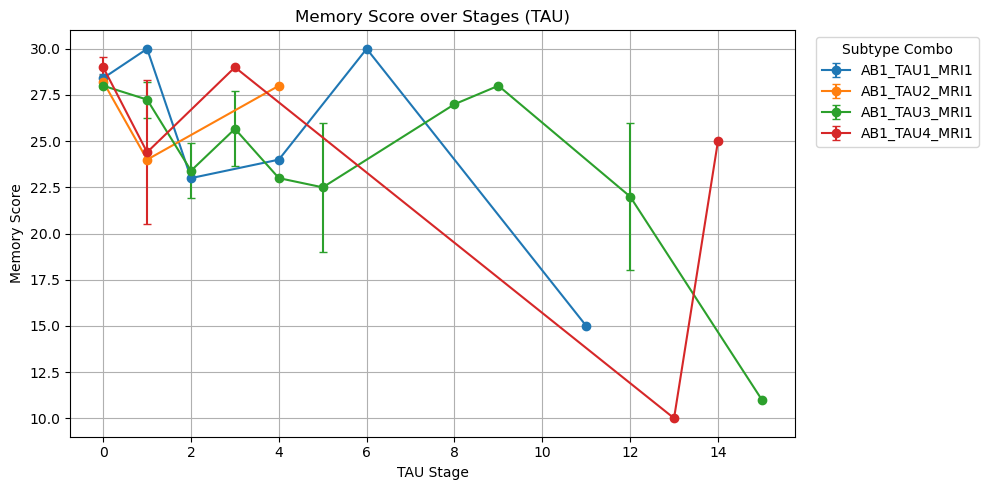


====== Memory Score Across Stages in MRI ======
AB1_TAU1_MRI1 | Slope = -2.804, r = -0.94, p = 0.0175
AB1_TAU2_MRI1 | Slope = -0.305, r = -0.28, p = 0.5931
AB1_TAU3_MRI1 | Slope = -0.138, r = -0.08, p = 0.9028
AB1_TAU4_MRI1 | Slope = -3.065, r = -1.00, p = 0.0348


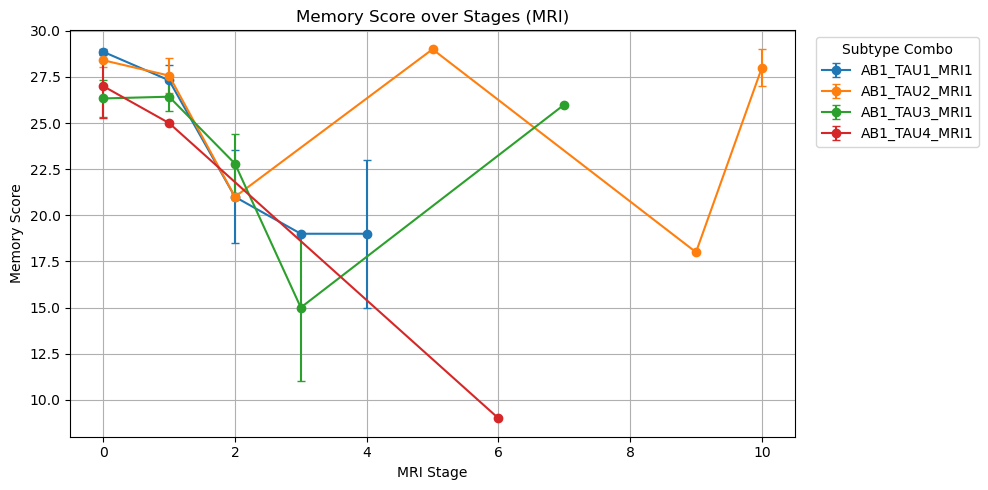

In [16]:
# Define SuStaIn stage column per modality
modality_stage_cols = {
    'AB': 'ab_ml_stage',
    'TAU': 'tau_ml_stage',
    'MRI': 'mri_ml_stage'
}

# Replace with your actual memory score column (e.g., 'ADNI_MEM')
memory_col = mmse_score  # or use mmse_score if defined earlier

# Filter combos with enough data
combo_col = 'subtype_combo'
valid_combos = final_combined_df[combo_col].value_counts()
valid_combos = valid_combos[valid_combos >= 10].index.tolist()  # Only combos with ≥10 subjects

# Loop through each modality stage
for modality, stage_col in modality_stage_cols.items():
    print(f"\n====== Memory Score Across Stages in {modality} ======")

    df = final_combined_df.copy()

    if stage_col not in df.columns:
        print(f"  Stage column '{stage_col}' not found.")
        continue

    if memory_col not in df.columns:
        print(f"  Memory score column '{memory_col}' not found.")
        continue

    plt.figure(figsize=(10, 5))

    for combo in sorted(valid_combos):
        sub_df = df[(df[combo_col] == combo) & (df[stage_col].notna())]

        grouped = sub_df.groupby(stage_col)[memory_col]
        means = grouped.mean()
        sems = grouped.sem()

        if means.empty:
            continue

        plt.errorbar(means.index, means.values, yerr=sems,
                     label=combo, marker='o', capsize=3)

        if len(means) > 1:
            slope, _, r, pval, _ = linregress(means.index, means.values)
            print(f"{combo} | Slope = {slope:.3f}, r = {r:.2f}, p = {pval:.4f}")

    plt.title(f"Memory Score over Stages ({modality})")
    plt.xlabel(f"{modality} Stage")
    plt.ylabel("Memory Score")
    plt.legend(title='Subtype Combo', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [17]:
# === Step 1: Load model predictions ===
triplet_df = pd.read_csv("predicted_triplet_scores.csv")

# === Step 2: Ensure all possible triplets are present ===
all_triplets = [f"AB{a}_TAU{t}_MRI{m}" for a in range(1, 3)
                                         for t in range(1, 5)
                                         for m in range(1, 5)]

triplet_score_dict = dict(zip(triplet_df["Triplet"], triplet_df["Score"]))
triplet_df_full = pd.DataFrame({
    "Triplet": all_triplets,
    "Predicted_Score": [triplet_score_dict.get(triplet, 0.0) for triplet in all_triplets]
})

# === Step 3: Model rank (tie-aware, alphabetic tiebreak) ===
triplet_df_full = triplet_df_full.sort_values(
    by=["Predicted_Score", "Triplet"], ascending=[False, True]
).reset_index(drop=True)
triplet_df_full["Model_Rank"] = range(1, len(triplet_df_full) + 1)

# === Step 4: Observed counts using subtype_combo ===
combo_counts = final_combined_df["subtype_combo"].value_counts().to_dict()
triplet_df_full["Observed_Count"] = triplet_df_full["Triplet"].map(combo_counts).fillna(0).astype(int)

# === Step 5: Observed rank (tie-aware) ===
triplet_df_full = triplet_df_full.sort_values(
    by=["Observed_Count", "Triplet"], ascending=[False, True]
).reset_index(drop=True)
triplet_df_full["Observed_Rank"] = range(1, len(triplet_df_full) + 1)

# === Step 6: Sort back to Triplet order ===
triplet_df_full = triplet_df_full.sort_values("Triplet").reset_index(drop=True)

# === Step 7: Spearman correlation ===
corr, pval = spearmanr(triplet_df_full["Model_Rank"], triplet_df_full["Observed_Rank"])
print(f"Spearman correlation between model and observed triplet rankings: r = {corr:.3f}, p = {pval:.4f}")

# === Step 8: Show top N triplets ===
top_n = 15
top_triplets = triplet_df_full.sort_values("Model_Rank").head(top_n)

# Display nicely
display_cols = ["Triplet", "Model_Rank", "Observed_Rank", "Observed_Count", "Predicted_Score"]
print(top_triplets[display_cols].to_string(index=False))


Spearman correlation between model and observed triplet rankings: r = 0.912, p = 0.0000
      Triplet  Model_Rank  Observed_Rank  Observed_Count  Predicted_Score
AB1_TAU2_MRI1           1              2             101         0.060772
AB1_TAU1_MRI1           2              1             142         0.010113
AB1_TAU3_MRI1           3              3              30         0.006901
AB1_TAU4_MRI1           4              4              13         0.001408
AB2_TAU2_MRI1           5              9               2         0.001329
AB1_TAU2_MRI2           6             12               1         0.000791
AB2_TAU1_MRI1           7             20               0         0.000597
AB1_TAU1_MRI2           8              5               3         0.000338
AB1_TAU2_MRI4           9             14               0         0.000237
AB1_TAU2_MRI3          10              8               2         0.000193
AB2_TAU3_MRI1          11             10               2         0.000170
AB1_TAU1_MRI4          1

## 2. Longitudinal Testsets

In [18]:
data_long_mri = pd.read_csv('Test_MRI_Modality_5.csv')
data_long_ab = pd.read_csv('Test_AB_Modality_6.csv')
data_long_tau = pd.read_csv('Test_TAU_Modality_7.csv')


# store biomarker labels as a variable
biomarkers_mri = data_long_mri.columns[11:16]
biomarkers_ab = data_long_ab.columns[10:15]
biomarkers_tau = data_long_tau.columns[10:15]

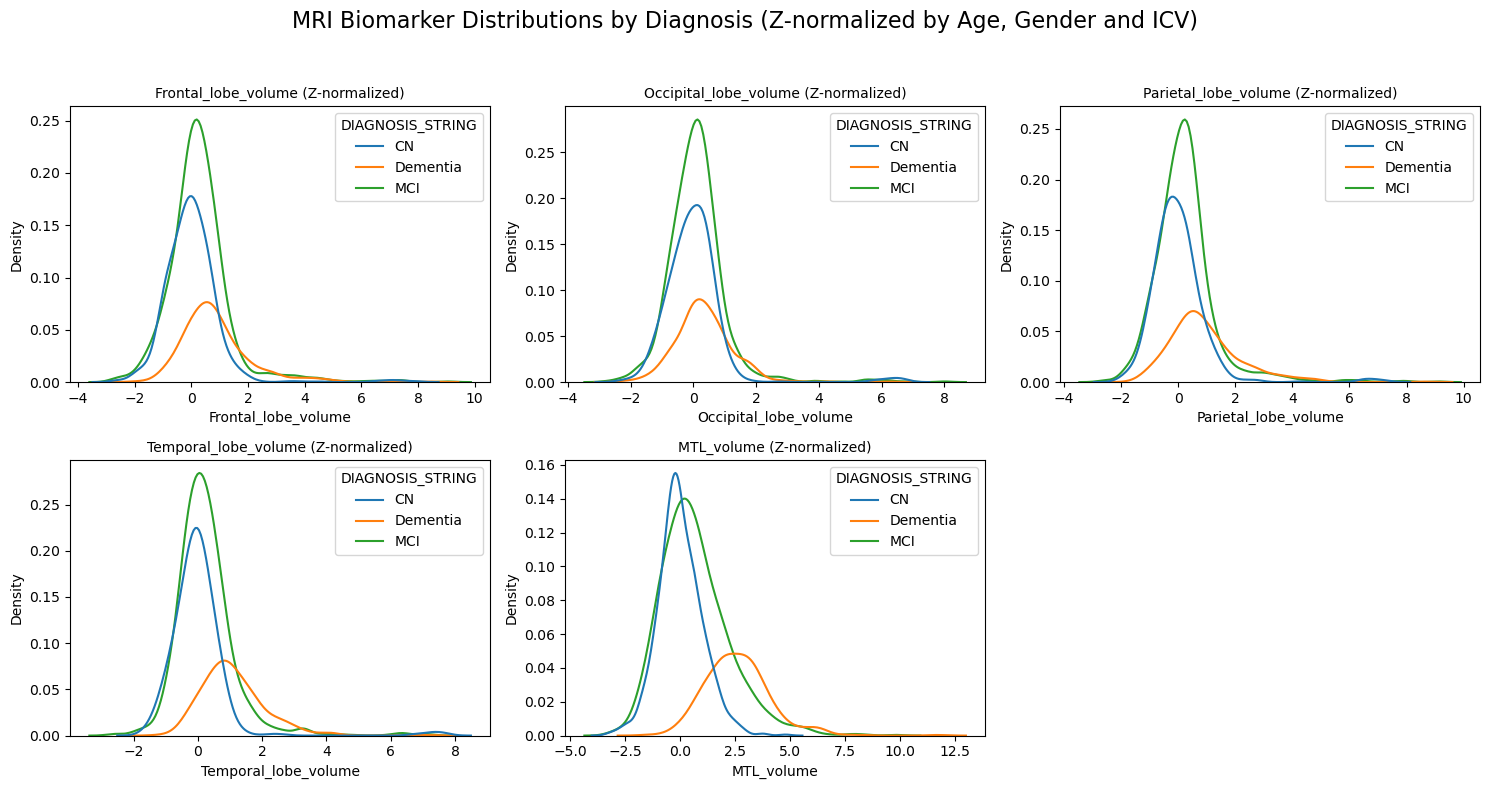

In [19]:
#Normalisation of the Multi MRI data 

# Make a copy of data_mri to store normalized values
zdata_long_mri = pd.DataFrame(data_long_mri.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_mri: 
    model = smf.wls(f'{biomarker} ~ Age + ICV_CorticalVolume + C(PTGENDER)', data=data_long_mri[data_long_mri['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_long_mri[['Age', 'ICV_CorticalVolume', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_long_mri[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_long_mri['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_long_mri['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_long_mri[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_mri)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_mri):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_long_mri, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("MRI Biomarker Distributions by Diagnosis (Z-normalized by Age, Gender and ICV)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



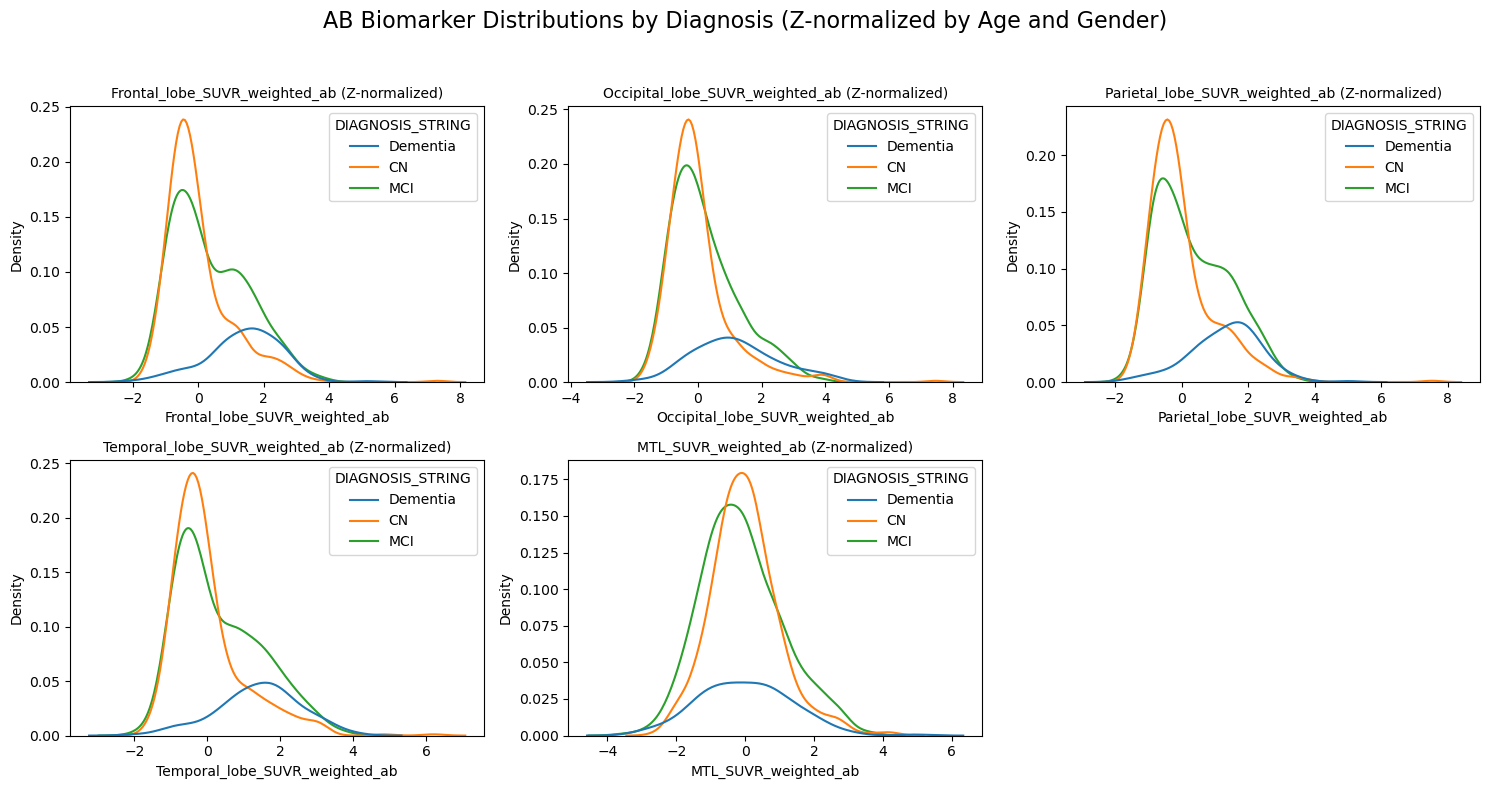

In [20]:
#Normalisation of the Multi AB data 

# Make a copy of data_mri to store normalized values
zdata_long_ab = pd.DataFrame(data_long_ab.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_ab: 
    model = smf.wls(f'{biomarker} ~ Age + C(PTGENDER)', data=data_long_ab[data_long_ab['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_long_ab[['Age', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_long_ab[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_long_ab['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_long_ab['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_long_ab[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_ab)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_ab):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_long_ab, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("AB Biomarker Distributions by Diagnosis (Z-normalized by Age and Gender)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


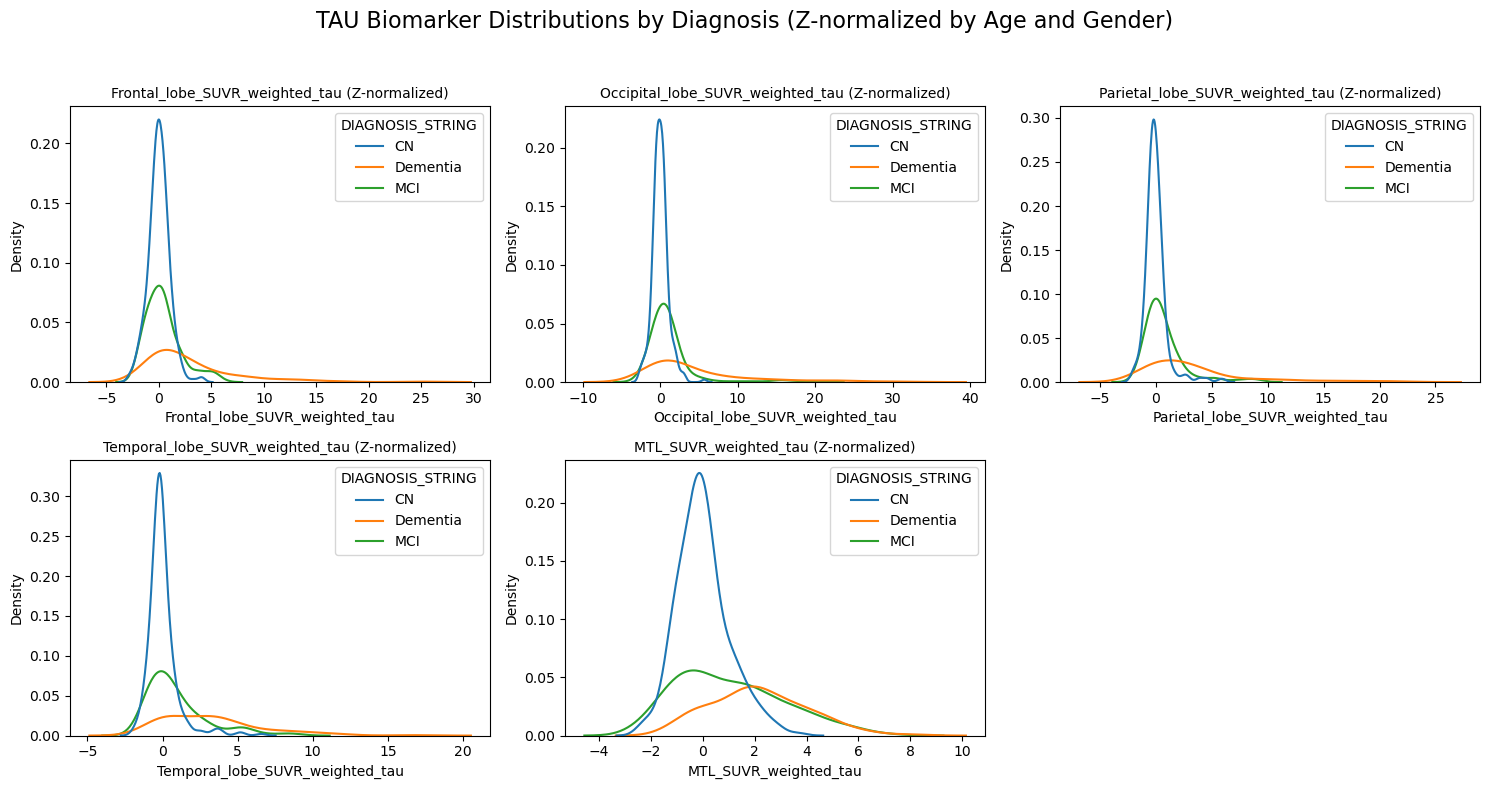

In [21]:
#Normalisation of the Multi TAU data 

# Make a copy of data_mri to store normalized values
zdata_long_tau = pd.DataFrame(data_long_tau.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_tau: 
    model = smf.wls(f'{biomarker} ~ Age + C(PTGENDER)', data=data_long_tau[data_long_tau['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_long_tau[['Age', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_long_tau[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_long_tau['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_long_tau['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_long_tau[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_tau)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_tau):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_long_tau, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("TAU Biomarker Distributions by Diagnosis (Z-normalized by Age and Gender)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [22]:
#Run the new data into the old models and assign subtype and stage per indivividual

# Assign subtypes/stages for each modality
results_long_mri, prob_long_mri_subtype, prob_long_mri_stage, prob_long_mri_subtype_stage = assign_sustain_subtypes(zdata_long_mri, biomarkers_mri, sustain_input_mri, samples_sequence_mri, samples_f_mri, "mri")
results_long_ab, prob_long_ab_subtype, prob_long_ab_stage, prob_long_ab_subtype_stage = assign_sustain_subtypes(zdata_long_ab, biomarkers_ab, sustain_input_ab, samples_sequence_ab, samples_f_ab, "ab")
results_long_tau, prob_long_tau_subtype, prob_long_tau_stage, prob_long_tau_subtype_stage = assign_sustain_subtypes(zdata_long_tau, biomarkers_tau, sustain_input_tau, samples_sequence_tau, samples_f_tau, "tau")

# Join results to the normalized z-scored dataframes
zdata_long_mri = zdata_long_mri.join(results_long_mri)
zdata_long_ab  = zdata_long_ab.join(results_long_ab)
zdata_long_tau = zdata_long_tau.join(results_long_tau)

# Sort by RID and Date
zdata_long_mri = zdata_long_mri.sort_values([rid, dat]).copy()
zdata_long_ab  = zdata_long_ab.sort_values([rid, dat]).copy()
zdata_long_tau = zdata_long_tau.sort_values([rid, dat]).copy()



In [23]:
# Compute subject assignment to subtype and stage consistency ---
def compute_consistency(df, modality, stage_diff_threshold=1):
    sub_col = f"{modality}_ml_subtype"
    stage_col = f"{modality}_ml_stage"

    results = []
    for rid, group in df.groupby("RID"):
        group_sorted = group.sort_values("EXAMDATE")
        
        # Subtype consistency
        subtypes = group_sorted[sub_col].dropna().unique()
        subtype_consistent = len(subtypes) == 1
        
        # Stage stability (max difference ≤ threshold)
        stages = group_sorted[stage_col].dropna().tolist()
        stage_stable = (max(stages) - min(stages)) <= stage_diff_threshold if stages else False
        
        results.append({
            "RID": rid,
            "subtype_consistent": subtype_consistent,
            "stage_stable": stage_stable
        })
    return pd.DataFrame(results)


# --- Overall summary ---
def consistency_overview(df, modality):
    total = len(df)
    consistent_subtype = df["subtype_consistent"].sum()
    stable_stage = df["stage_stable"].sum()
    both_consistent = ((df["subtype_consistent"]) & (df["stage_stable"])).sum()

    print(f"\n--- {modality.upper()} CONSISTENCY SUMMARY ---")
    print(f"Total subjects: {total}")
    print(f"Consistent subtype: {consistent_subtype} ({consistent_subtype/total:.1%})")
    print(f"Stable stage (≤1 diff): {stable_stage} ({stable_stage/total:.1%})")
    print(f"Both consistent: {both_consistent} ({both_consistent/total:.1%})")

# Diagnosis shift quantification
def quantify_diagnosis_shifts(df, modality):
    total_subjects = df["RID"].nunique()
    dx_shift_counts = Counter()
    shifted_subjects = 0

    for rid, group in df.groupby("RID"):
        dx_ordered = group.sort_values("EXAMDATE")[dx].dropna().tolist()
        dx_unique = list(pd.Series(dx_ordered).drop_duplicates())

        if len(dx_unique) > 1:
            shifted_subjects += 1
            for i in range(1, len(dx_ordered)):
                if dx_ordered[i] != dx_ordered[i-1]:
                    dx_shift_counts[(dx_ordered[i-1], dx_ordered[i])] += 1

    print(f"\n{modality} DIAGNOSIS SHIFT ANALYSIS")
    print(f"Total subjects: {total_subjects}")
    print(f"Subjects with diagnosis shift: {shifted_subjects} ({shifted_subjects / total_subjects:.1%})")
    print("\nMost common diagnosis transitions (from → to):")
    for (from_dx, to_dx), count in dx_shift_counts.most_common():
        proportion = count / total_subjects
        print(f"{from_dx} → {to_dx}: {count} times ({proportion:.1%})")

# Subtype shift quantification
def quantify_subtype_shifts(df, modality):
    sub_col = f"{modality}_ml_subtype"

    shift_counts = Counter()
    total_subjects = df["RID"].nunique()
    shifted_subjects = 0

    for rid, group in df.groupby("RID"):
        subtypes = list(group[sub_col].dropna().unique())
        if len(subtypes) > 1:
            shifted_subjects += 1
            ordered = group.sort_values("EXAMDATE")[sub_col].tolist()
            for i in range(1, len(ordered)):
                if ordered[i] != ordered[i-1]:
                    shift_counts[(ordered[i-1], ordered[i])] += 1

    print(f"\n{modality.upper()} SUBTYPE SHIFT ANALYSIS")
    print(f"Total subjects: {total_subjects}")
    print(f"Subjects with subtype shift: {shifted_subjects} ({shifted_subjects / total_subjects:.1%})")
    print("\nMost common subtype transitions (from → to):")
    for (from_sub, to_sub), count in shift_counts.most_common():
        proportion = count / total_subjects
        print(f"{from_sub} → {to_sub}: {count} times ({proportion:.1%})")



# Create consistency tables for each modality, summaries, run quantifications for diagnosisand subtypes
#AB
ab_consistency = compute_consistency(zdata_long_ab, "ab")
consistency_overview(ab_consistency, "ab")
quantify_diagnosis_shifts(zdata_long_ab, "AB") 
quantify_subtype_shifts(zdata_long_ab, "ab")
#TAU
tau_consistency = compute_consistency(zdata_long_tau, "tau")
consistency_overview(tau_consistency, "tau")
quantify_diagnosis_shifts(zdata_long_tau, "TAU") 
quantify_subtype_shifts(zdata_long_tau, "tau")
#MRI
mri_consistency = compute_consistency(zdata_long_mri, "mri")
consistency_overview(mri_consistency, "mri")
quantify_diagnosis_shifts(zdata_long_mri, "MRI") 
quantify_subtype_shifts(zdata_long_mri, "mri")



--- AB CONSISTENCY SUMMARY ---
Total subjects: 464
Consistent subtype: 456 (98.3%)
Stable stage (≤1 diff): 356 (76.7%)
Both consistent: 355 (76.5%)

AB DIAGNOSIS SHIFT ANALYSIS
Total subjects: 464
Subjects with diagnosis shift: 118 (25.4%)

Most common diagnosis transitions (from → to):
MCI → Dementia: 67 times (14.4%)
CN → MCI: 29 times (6.2%)
MCI → CN: 23 times (5.0%)
CN → Dementia: 4 times (0.9%)
Dementia → MCI: 1 times (0.2%)

AB SUBTYPE SHIFT ANALYSIS
Total subjects: 464
Subjects with subtype shift: 8 (1.7%)

Most common subtype transitions (from → to):
0.0 → 1.0: 6 times (1.3%)
1.0 → 0.0: 3 times (0.6%)

--- TAU CONSISTENCY SUMMARY ---
Total subjects: 234
Consistent subtype: 170 (72.6%)
Stable stage (≤1 diff): 203 (86.8%)
Both consistent: 153 (65.4%)

TAU DIAGNOSIS SHIFT ANALYSIS
Total subjects: 234
Subjects with diagnosis shift: 42 (17.9%)

Most common diagnosis transitions (from → to):
MCI → Dementia: 20 times (8.5%)
CN → MCI: 16 times (6.8%)
MCI → CN: 7 times (3.0%)
Dementia 

In [24]:
# Detect diagnosis regressions (DEM->MCI->CN)
def find_diagnosis_regressions(df, dx_col=dx, rid_col="RID", date_col=dat):
    # Define diagnosis severity order
    severity = {"CN": 0, "MCI": 1, "Dementia": 2}

    regressions = []

    for rid, group in df.groupby(rid_col):
        group_sorted = group.sort_values(date_col)
        dx_list = group_sorted[dx_col].dropna().tolist()

        if len(dx_list) < 2:
            continue

        dx_dates = group_sorted[date_col].tolist()

        for i in range(1, len(dx_list)):
            prev_dx = dx_list[i-1]
            curr_dx = dx_list[i]
            if prev_dx in severity and curr_dx in severity:
                if severity[curr_dx] < severity[prev_dx]:  # regression detected
                    regressions.append({
                        "RID": rid,
                        "from_dx": prev_dx,
                        "to_dx": curr_dx,
                        "from_date": dx_dates[i-1],
                        "to_date": dx_dates[i],
                    })

    return pd.DataFrame(regressions)

# Apply to each modality
regress_ab = find_diagnosis_regressions(zdata_long_ab, dx_col=dx)
regress_tau = find_diagnosis_regressions(zdata_long_tau, dx_col=dx)
regress_mri = find_diagnosis_regressions(zdata_long_mri, dx_col=dx)

# Display results
print("\n--- AB DIAGNOSIS REGRESSIONS ---")
print(regress_ab)

print("\n--- TAU DIAGNOSIS REGRESSIONS ---")
print(regress_tau)

print("\n--- MRI DIAGNOSIS REGRESSIONS ---")
print(regress_mri)



--- AB DIAGNOSIS REGRESSIONS ---
     RID   from_dx to_dx   from_date     to_date
0   2007       MCI    CN  2010-07-06  2013-05-09
1   2010       MCI    CN  2010-07-08  2012-07-12
2   2018       MCI    CN  2012-06-13  2018-12-04
3   2073       MCI    CN  2012-09-18  2014-10-07
4   2184       MCI    CN  2010-12-01  2017-10-09
5   2233       MCI    CN  2014-03-05  2019-01-29
6   2394       MCI    CN  2019-07-30  2023-10-26
7   4004       MCI    CN  2015-04-30  2017-10-10
8   4061       MCI    CN  2013-06-25  2019-11-26
9   4072       MCI    CN  2013-07-10  2015-07-24
10  4168       MCI    CN  2013-09-12  2015-09-14
11  4184       MCI    CN  2013-09-12  2017-10-30
12  4214       MCI    CN  2013-10-16  2015-10-16
13  4310       MCI    CN  2011-11-11  2013-11-08
14  4381       MCI    CN  2014-02-21  2016-02-03
15  4419       MCI    CN  2011-12-22  2013-12-17
16  4444       MCI    CN  2014-03-18  2016-02-23
17  4624       MCI    CN  2012-06-13  2014-08-15
18  4641  Dementia   MCI  2012-04-2

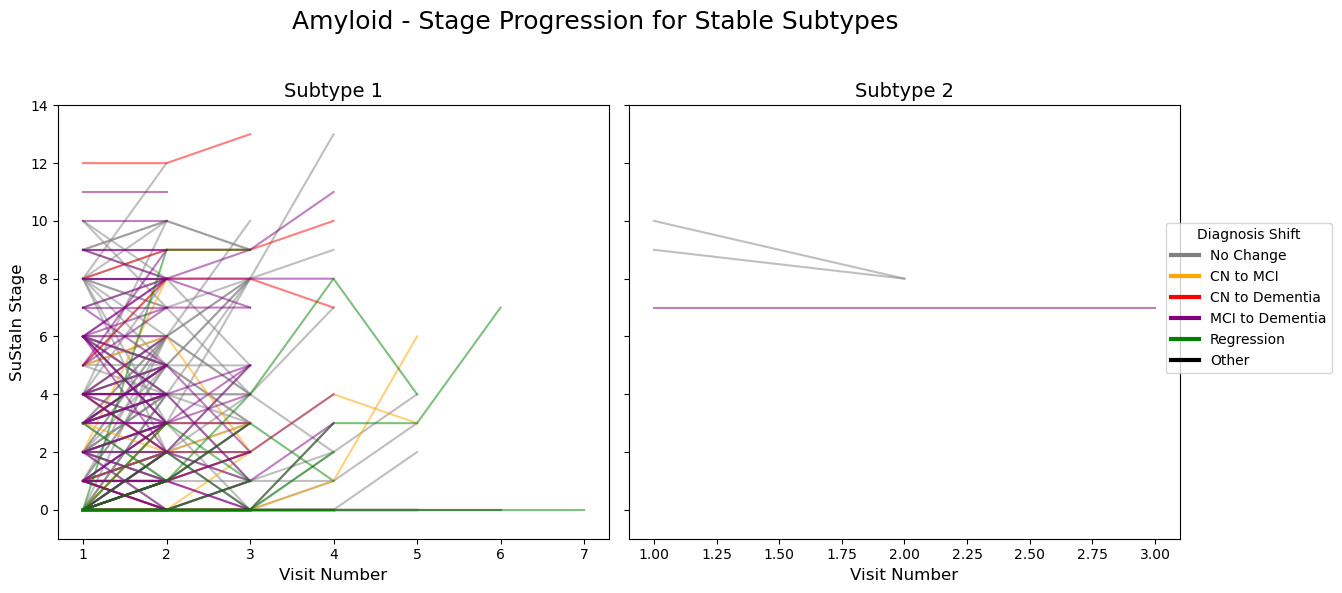

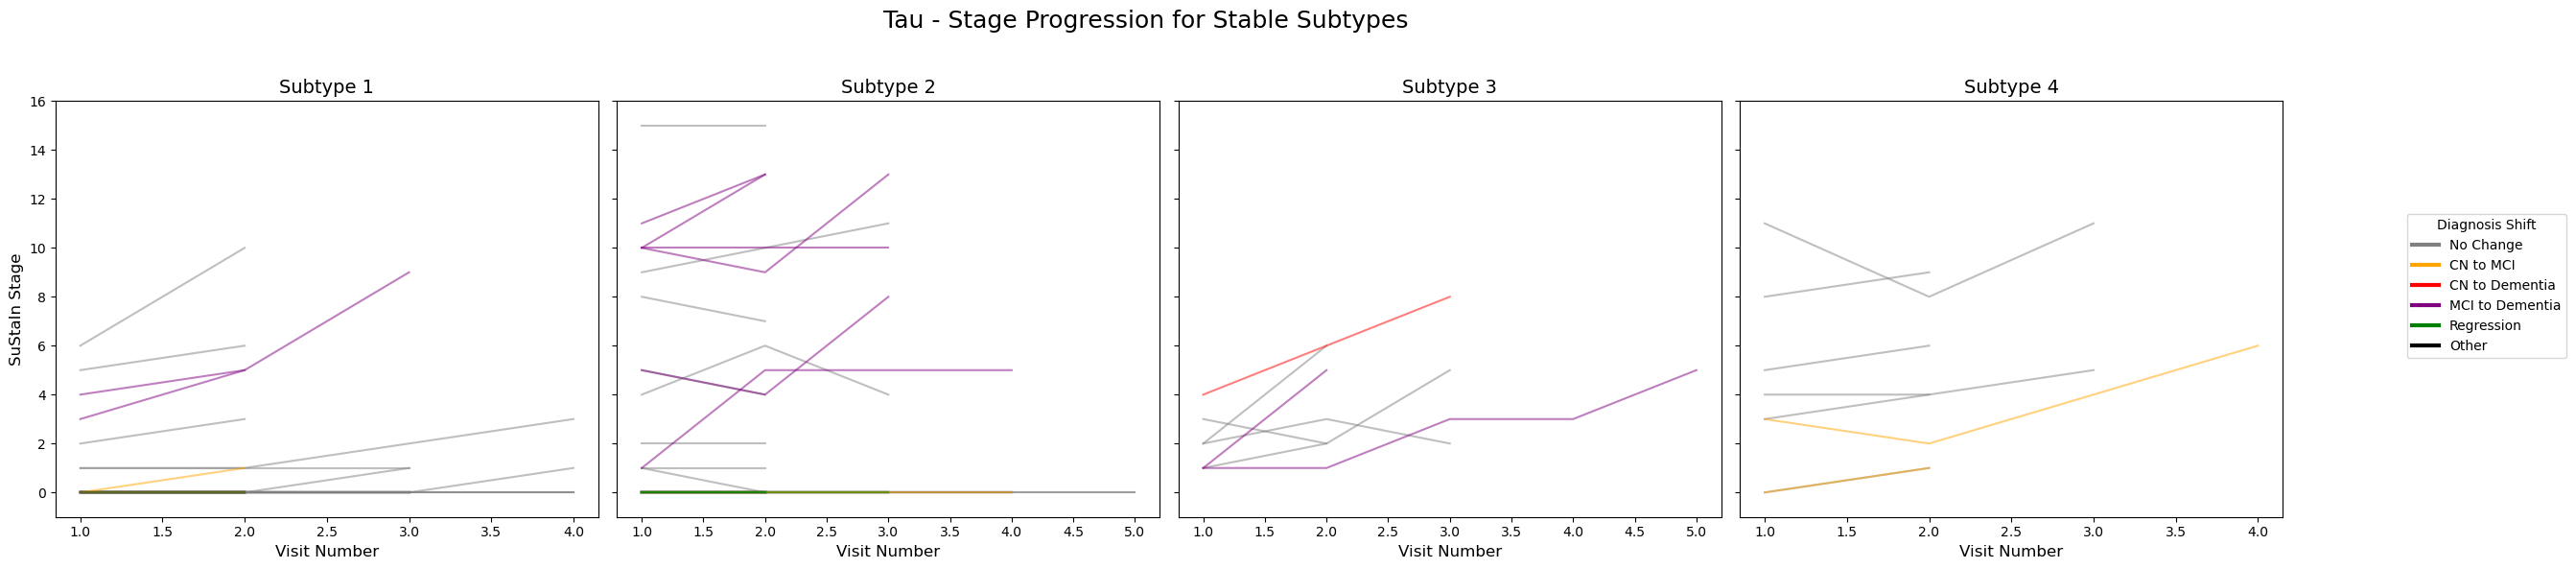

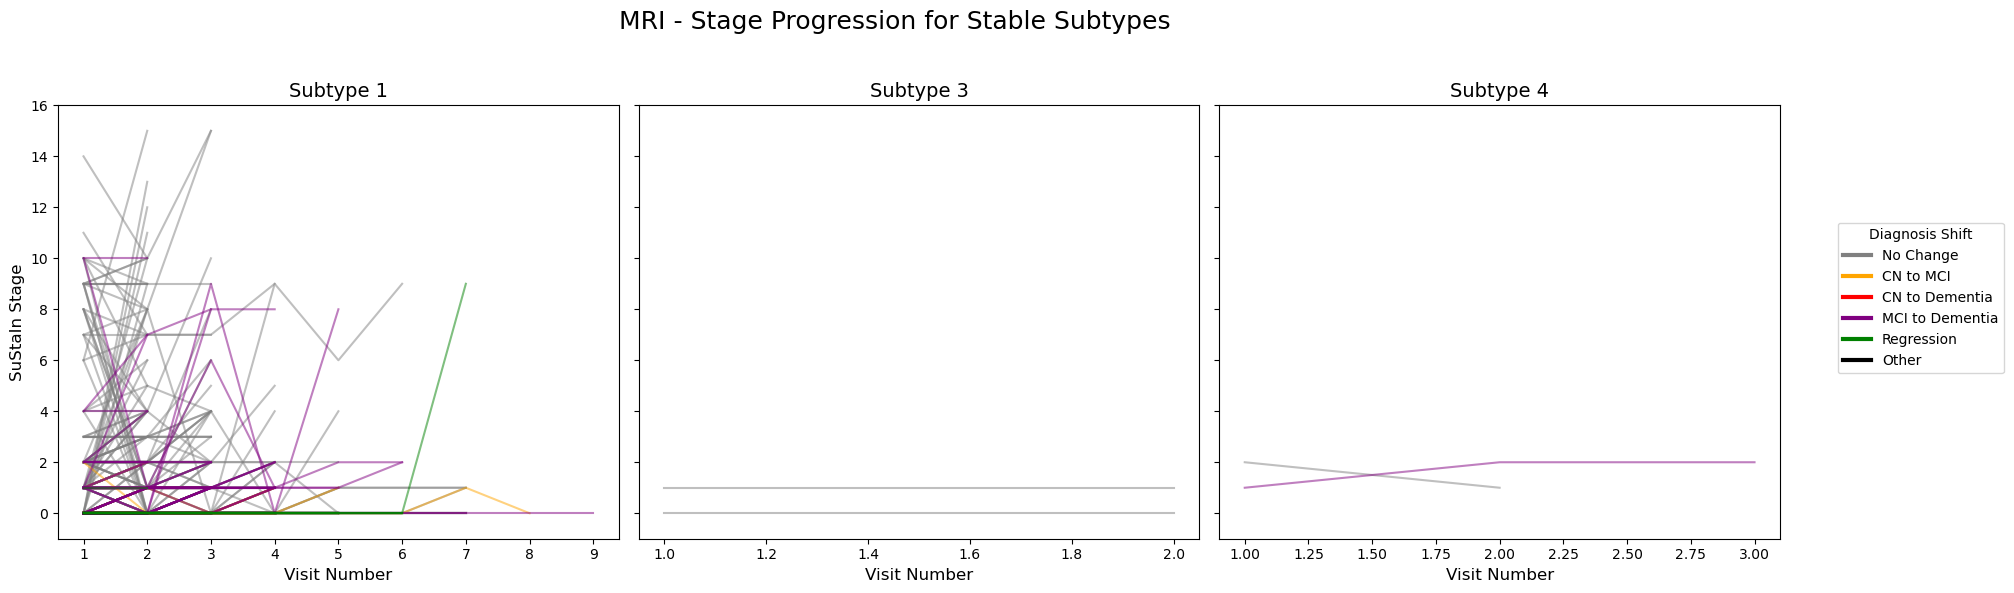

Subtype  Diagnosis_Shift Stage_Change  Count  Percentage  \
0       0.0   CN to Dementia     Increase      3   75.000000   
1       0.0   CN to Dementia       Stable      1   25.000000   
2       0.0        CN to MCI     Decrease      3   12.500000   
3       0.0        CN to MCI     Increase      7   29.166667   
4       0.0        CN to MCI       Stable     14   58.333333   
5       0.0  MCI to Dementia     Decrease     17   26.562500   
6       0.0  MCI to Dementia     Increase     23   35.937500   
7       0.0  MCI to Dementia       Stable     24   37.500000   
8       0.0        No Change     Decrease     22    6.432749   
9       0.0        No Change     Increase     68   19.883041   
10      0.0        No Change       Stable    252   73.684211   
11      0.0       Regression     Decrease      1    5.263158   
12      0.0       Regression     Increase      7   36.842105   
13      0.0       Regression       Stable     11   57.894737   
14      1.0  MCI to Dementia       Stable      1  100.000000   
15      1.0        No Change     Decrease      2  100.000000   

    Mean_Stage_Change  
0            1.250000  
1            1.250000  
2            0.625000  
3            0.625000  
4            0.625000  
5            0.328125  
6            0.328125  
7            0.328125  
8            0.336257  
9            0.336257  
10           0.336257  
11           1.210526  
12           1.210526  
13           1.210526  
14           0.000000  
15          -1.500000

Subtype  Diagnosis_Shift Stage_Change  Count  Percentage  \
0       0.0        CN to MCI     Increase      1   25.000000   
1       0.0        CN to MCI       Stable      3   75.000000   
2       0.0  MCI to Dementia     Increase      2   66.666667   
3       0.0  MCI to Dementia       Stable      1   33.333333   
4       0.0        No Change     Increase      6    8.108108   
5       0.0        No Change       Stable     68   91.891892   
6       0.0       Regression       Stable      1  100.000000   
7       1.0        CN to MCI       Stable      4  100.000000   
8       1.0  MCI to Dementia     Increase      5   83.333333   
9       1.0  MCI to Dementia       Stable      1   16.666667   
10      1.0        No Change     Decrease      3    5.000000   
11      1.0        No Change     Increase      1    1.666667   
12      1.0        No Change       Stable     56   93.333333   
13      1.0       Regression       Stable      3  100.000000   
14      2.0   CN to Dementia     Increase      1  100.000000   
15      2.0  MCI to Dementia     Increase      2  100.000000   
16      2.0        No Change     Increase      3   75.000000   
17      2.0        No Change       Stable      1   25.000000   
18      3.0        CN to MCI     Increase      2  100.000000   
19      3.0        No Change     Increase      5   83.333333   
20      3.0        No Change       Stable      1   16.666667   

    Mean_Stage_Change  
0            0.250000  
1            0.250000  
2            2.333333  
3            2.333333  
4            0.135135  
5            0.135135  
6            0.000000  
7            0.000000  
8            2.500000  
9            2.500000  
10          -0.016667  
11          -0.016667  
12          -0.016667  
13           0.000000  
14           4.000000  
15           4.000000  
16           1.750000  
17           1.750000  
18           2.000000  
19           0.833333  
20           0.833333

Subtype  Diagnosis_Shift Stage_Change  Count  Percentage  \
0       0.0   CN to Dementia     Increase      1  100.000000   
1       0.0        CN to MCI     Decrease      1    2.941176   
2       0.0        CN to MCI     Increase      4   11.764706   
3       0.0        CN to MCI       Stable     29   85.294118   
4       0.0  MCI to Dementia     Decrease      2    2.531646   
5       0.0  MCI to Dementia     Increase     29   36.708861   
6       0.0  MCI to Dementia       Stable     48   60.759494   
7       0.0        No Change     Decrease     25    3.419973   
8       0.0        No Change     Increase    121   16.552668   
9       0.0        No Change       Stable    585   80.027360   
10      0.0       Regression     Increase      1    3.333333   
11      0.0       Regression       Stable     29   96.666667   
12      2.0        No Change       Stable      2  100.000000   
13      3.0  MCI to Dementia     Increase      1  100.000000   
14      3.0        No Change     Decrease      1  100.000000   

    Mean_Stage_Change  
0            1.000000  
1            0.088235  
2            0.088235  
3            0.088235  
4            0.569620  
5            0.569620  
6            0.569620  
7            0.214774  
8            0.214774  
9            0.214774  
10           0.300000  
11           0.300000  
12           0.000000  
13           1.000000  
14          -1.000000

In [45]:
# Diagnosis shift function 
def get_diag_shift(group):
    diag_start = group.iloc[0][dx]
    diag_end = group.iloc[-1][dx]
    if diag_start == diag_end:
        return "No Change"
    elif diag_start == "CN" and diag_end == "MCI":
        return "CN to MCI"
    elif diag_start == "CN" and diag_end == "Dementia":
        return "CN to Dementia"
    elif diag_start == "MCI" and diag_end == "Dementia":
        return "MCI to Dementia"
    elif (diag_start == "Dementia" and diag_end in ["MCI", "CN"]) or \
         (diag_start == "MCI" and diag_end == "CN"):
        return "Regression"
    else:
        return "Other"

# Colors for diagnosis shift
shift_colors = {
    "No Change": "gray",
    "CN to MCI": "orange",
    "CN to Dementia": "red",
    "MCI to Dementia": "purple",
    "Regression": "green",
    "Other": "black"
}

def plot_stable_subtypes_by_stage(df, modality_label, mod):
    df = df.sort_values(["RID", dat]).copy()
    df["Visit_Number"] = df.groupby("RID").cumcount() + 1

    # Add diagnosis shift per subject
    diag_shift_per_subject = df.groupby("RID").apply(get_diag_shift).reset_index(name="Diagnosis_Shift")
    df = df.merge(diag_shift_per_subject, on="RID", how="left")

    subtype_col = f"{mod}_ml_subtype"
    stage_col = f"{mod}_ml_stage"

    # Keep only subjects stable in subtype
    stable_subjects = df.groupby("RID")[subtype_col].nunique()
    stable_subjects = stable_subjects[stable_subjects == 1].index
    df_stable = df[df["RID"].isin(stable_subjects)].copy()
    df_stable["Subtype"] = df_stable[subtype_col]

    subtypes = sorted(df_stable["Subtype"].dropna().unique())

    n_subtypes = len(subtypes)
    fig, axes = plt.subplots(nrows=1, ncols=n_subtypes, figsize=(6 * n_subtypes, 6), sharey=True)
    if n_subtypes == 1:
        axes = [axes]

    summary = []

    for i, subtype in enumerate(subtypes):
        ax = axes[i]
        sub_df = df_stable[df_stable["Subtype"] == subtype]
        ax.set_title(f"Subtype {int(subtype)+1}", fontsize=14)

        for shift, color in shift_colors.items():
            shift_df = sub_df[sub_df["Diagnosis_Shift"] == shift]
            subject_ids = shift_df["RID"].unique()

            for rid in subject_ids:
                subj_data = shift_df[shift_df["RID"] == rid].sort_values("Visit_Number")
                stages = subj_data[stage_col].values

                if len(stages) < 2:
                    direction = "Stable"
                    stage_diff = 0
                else:
                    if all(x == stages[0] for x in stages):
                        direction = "Stable"
                        stage_diff = 0
                    else:
                        if stages[-1] > stages[0]:
                            direction = "Increase"
                        elif stages[-1] < stages[0]:
                            direction = "Decrease"
                        else:
                            direction = "Stable"
                        stage_diff = stages[-1] - stages[0]

                summary.append({
                    "Subtype": subtype,
                    "Diagnosis_Shift": shift,
                    "RID": rid,
                    "Stage_Change": direction,
                    "Stage_Diff": stage_diff  # Add stage difference
                })

                # Plot progression line
                ax.plot(subj_data["Visit_Number"], subj_data[stage_col], color=color, alpha=0.5)

        ax.set_xlabel("Visit Number", fontsize=12)
        ax.set_ylim(df_stable[stage_col].min() - 1, df_stable[stage_col].max() + 1)
        if i == 0:
            ax.set_ylabel("SuStaIn Stage", fontsize=12)

    handles = [plt.Line2D([0], [0], color=color, lw=3) for color in shift_colors.values()]
    fig.legend(handles, shift_colors.keys(), title="Diagnosis Shift", loc="center right", bbox_to_anchor=(1.12, 0.5))
    fig.suptitle(f"{modality_label} - Stage Progression for Stable Subtypes", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Create summary DataFrame
    summary_df = pd.DataFrame(summary)

    # Count and percent by Subtype, Diagnosis_Shift, Stage_Change
    count_df = summary_df.groupby(["Subtype", "Diagnosis_Shift", "Stage_Change"]).size().reset_index(name="Count")
    count_df["Percentage"] = count_df.groupby(["Subtype", "Diagnosis_Shift"])["Count"].transform(lambda x: 100 * x / x.sum())

    # ✅ Add mean stage increase per group (Subtype + Diagnosis_Shift)
    mean_stage_change = summary_df.groupby(["Subtype", "Diagnosis_Shift"])["Stage_Diff"].mean().reset_index(name="Mean_Stage_Change")

    # Merge into count_df
    count_df = count_df.merge(mean_stage_change, on=["Subtype", "Diagnosis_Shift"], how="left")

    return count_df, summary_df

# Run modality dataframes:
ab_summary, ab_subject_level = plot_stable_subtypes_by_stage(zdata_long_ab, "Amyloid", "ab")
tau_summary, tau_subject_level = plot_stable_subtypes_by_stage(zdata_long_tau, "Tau", "tau")
mri_summary, mri_subject_level = plot_stable_subtypes_by_stage(zdata_long_mri, "MRI", "mri")



display.display(ab_summary)
display.display(tau_summary)
display.display(mri_summary)


In [28]:
from IPython.display import display

def compute_stage_change_proportions(subject_level_df, modality_name):
    progression_shifts = ["CN to MCI", "CN to Dementia", "MCI to Dementia"]
    progression_df = subject_level_df[subject_level_df["Diagnosis_Shift"].isin(progression_shifts)]

    total_progressors = progression_df["RID"].nunique()

    stage_stats = (
        progression_df.groupby("Stage_Change")["RID"].nunique()
        .reset_index(name="Count")
    )
    stage_stats["Proportion"] = stage_stats["Count"] / total_progressors * 100
    stage_stats["Modality"] = modality_name
    stage_stats["Total_Progressors"] = total_progressors

    return stage_stats


# Compute stats for each modality
ab_stats = compute_stage_change_proportions(ab_subject_level, "Amyloid")
tau_stats = compute_stage_change_proportions(tau_subject_level, "Tau")
mri_stats = compute_stage_change_proportions(mri_subject_level, "MRI")

# Combine modality-specific stats
combined_stats = pd.concat([ab_stats, tau_stats, mri_stats], ignore_index=True)

# Compute overall combined stats
all_progressors = pd.concat([ab_subject_level, tau_subject_level, mri_subject_level], ignore_index=True)
progression_shifts = ["CN to MCI", "CN to Dementia", "MCI to Dementia"]
all_progressors = all_progressors[all_progressors["Diagnosis_Shift"].isin(progression_shifts)]

overall_total = all_progressors["RID"].nunique()

overall_stats = (
    all_progressors.groupby("Stage_Change")["RID"].nunique()
    .reset_index(name="Count")
)
overall_stats["Proportion"] = overall_stats["Count"] / overall_total * 100
overall_stats["Modality"] = "Overall"
overall_stats["Total_Progressors"] = overall_total

# Append overall stats to combined
final_stats = pd.concat([combined_stats, overall_stats], ignore_index=True)

# Set custom order for Modality so Overall is last
modality_order = ["Amyloid", "Tau", "MRI", "Overall"]
final_stats["Modality"] = pd.Categorical(final_stats["Modality"], categories=modality_order, ordered=True)

# Pivot and sort
final_summary_table = (
    final_stats.pivot_table(
        index=["Modality", "Total_Progressors"],
        columns="Stage_Change",
        values=["Count", "Proportion"],
        fill_value=0
    )
    .sort_index(axis=1, level=1)
    .sort_index(level=0)  # Sort by Modality with custom order
)

display(final_summary_table)


Count Proportion    Count Proportion  Count  \
Stage_Change               Decrease   Decrease Increase   Increase Stable   
Modality Total_Progressors                                                  
Amyloid  93                      20  21.505376       33  35.483871     40   
Tau      22                       0   0.000000       13  59.090909      9   
MRI      115                      3   2.608696       35  30.434783     77   
Overall  174                     23  13.218391       71  40.804598    110   

                           Proportion  
Stage_Change                   Stable  
Modality Total_Progressors             
Amyloid  93                 43.010753  
Tau      22                 40.909091  
MRI      115                66.956522  
Overall  174                63.218391

In [42]:
from IPython.display import display
import pandas as pd

def compute_stage_change_counts(subject_level_df, modality_name):
    progression_shifts = ["CN to MCI", "CN to Dementia", "MCI to Dementia"]
    progression_df = subject_level_df[subject_level_df["Diagnosis_Shift"].isin(progression_shifts)]

    # Count unique subjects per Stage_Change category
    stage_counts = (
        progression_df.groupby("Stage_Change")["RID"].nunique()
        .reset_index(name="Count")
    )

    # Total subjects across all categories for this modality (sum of counts)
    total_counts = stage_counts["Count"].sum()

    # Calculate proportion per category relative to total subjects in all categories (sums to 100%)
    stage_counts["Proportion"] = stage_counts["Count"] / total_counts * 100
    stage_counts["Modality"] = modality_name
    stage_counts["Total_Progressors"] = total_counts

    return stage_counts

# Compute counts and proportions for each modality
ab_stats = compute_stage_change_counts(ab_subject_level, "Amyloid")
tau_stats = compute_stage_change_counts(tau_subject_level, "Tau")
mri_stats = compute_stage_change_counts(mri_subject_level, "MRI")

# Combine modality-specific stats
combined_stats = pd.concat([ab_stats, tau_stats, mri_stats], ignore_index=True)

# Compute Overall counts and proportions by combining all modalities first
all_progressors = pd.concat([ab_subject_level, tau_subject_level, mri_subject_level], ignore_index=True)
progression_shifts = ["CN to MCI", "CN to Dementia", "MCI to Dementia"]
all_progressors = all_progressors[all_progressors["Diagnosis_Shift"].isin(progression_shifts)]

# Deduplicate per RID and Stage_Change for overall calculation
all_progressors_unique = all_progressors.drop_duplicates(subset=["RID", "Stage_Change"])

# Compute overall counts
overall_stage_counts = (
    all_progressors_unique.groupby("Stage_Change")["RID"].nunique()
    .reset_index(name="Count")
)

overall_total_counts = overall_stage_counts["Count"].sum()
overall_stage_counts["Proportion"] = overall_stage_counts["Count"] / overall_total_counts * 100
overall_stage_counts["Modality"] = "Overall"
overall_stage_counts["Total_Progressors"] = overall_total_counts

# Append overall stats to combined
final_stats = pd.concat([combined_stats, overall_stage_counts], ignore_index=True)

# Set custom order for Modality so Overall is last
modality_order = ["Amyloid", "Tau", "MRI", "Overall"]
final_stats["Modality"] = pd.Categorical(final_stats["Modality"], categories=modality_order, ordered=True)

# Pivot for clean display
final_summary_table = (
    final_stats.pivot_table(
        index=["Modality", "Total_Progressors"],
        columns="Stage_Change",
        values=["Count", "Proportion"],
        fill_value=0
    )
    .sort_index(axis=1, level=1)
    .sort_index(level=0)  # Sort by Modality with custom order
)

print("Diagnosis worsening vs Stage progression for subjects with stable subtype assignment (deduplicated overall)")
display(final_summary_table)


Diagnosis worsening vs Stage progression for subjects with stable subtype assignment (deduplicated overall)


Count Proportion    Count Proportion  Count  \
Stage_Change               Decrease   Decrease Increase   Increase Stable   
Modality Total_Progressors                                                  
Amyloid  93                      20  21.505376       33  35.483871     40   
Tau      22                       0   0.000000       13  59.090909      9   
MRI      115                      3   2.608696       35  30.434783     77   
Overall  204                     23  11.274510       71  34.803922    110   

                           Proportion  
Stage_Change                   Stable  
Modality Total_Progressors             
Amyloid  93                 43.010753  
Tau      22                 40.909091  
MRI      115                66.956522  
Overall  204                53.921569

In [41]:
# Get regression RIDs from detection
ab_regression_rids = set(regress_ab["RID"])
tau_regression_rids = set(regress_tau["RID"])
mri_regression_rids = set(regress_mri["RID"])

def compute_stage_change_counts(subject_level_df, modality_name, regression_rids):
    # Filter for subjects that actually regressed
    progression_df = subject_level_df[subject_level_df["RID"].isin(regression_rids)]

    # Count unique subjects per Stage_Change category
    stage_counts = (
        progression_df.groupby("Stage_Change")["RID"].nunique()
        .reset_index(name="Count")
    )

    total_counts = stage_counts["Count"].sum()
    stage_counts["Proportion"] = stage_counts["Count"] / total_counts * 100
    stage_counts["Modality"] = modality_name
    stage_counts["Total_Progressors"] = total_counts

    return stage_counts

# Apply using detected regression RIDs
ab_stats = compute_stage_change_counts(ab_subject_level, "Amyloid", ab_regression_rids)
tau_stats = compute_stage_change_counts(tau_subject_level, "Tau", tau_regression_rids)
mri_stats = compute_stage_change_counts(mri_subject_level, "MRI", mri_regression_rids)

# Combine modality-specific stats
combined_stats = pd.concat([ab_stats, tau_stats, mri_stats], ignore_index=True)

# Compute overall
all_regression_rids = ab_regression_rids.union(tau_regression_rids).union(mri_regression_rids)
all_progressors = pd.concat([ab_subject_level, tau_subject_level, mri_subject_level], ignore_index=True)
overall_stage_counts = (
    all_progressors[all_progressors["RID"].isin(all_regression_rids)]
    .groupby("Stage_Change")["RID"].nunique()
    .reset_index(name="Count")
)

overall_total_counts = overall_stage_counts["Count"].sum()
overall_stage_counts["Proportion"] = overall_stage_counts["Count"] / overall_total_counts * 100
overall_stage_counts["Modality"] = "Overall"
overall_stage_counts["Total_Progressors"] = overall_total_counts

# Append overall
final_stats = pd.concat([combined_stats, overall_stage_counts], ignore_index=True)

# Set custom order
modality_order = ["Amyloid", "Tau", "MRI", "Overall"]
final_stats["Modality"] = pd.Categorical(final_stats["Modality"], categories=modality_order, ordered=True)

# Pivot for clean display
final_summary_table = (
    final_stats.pivot_table(
        index=["Modality", "Total_Progressors"],
        columns="Stage_Change",
        values=["Count", "Proportion"],
        fill_value=0
    )
    .sort_index(axis=1, level=1)
    .sort_index(level=0)
)

print("Diagnosis regression vs Stage progression for subjects with stable subtype assignment")
display(final_summary_table)


Diagnosis regression vs Stage progression for subjects with stable subtype assignment


Count Proportion    Count Proportion  Count  \
Stage_Change               Decrease   Decrease Increase   Increase Stable   
Modality Total_Progressors                                                  
Amyloid  23                       2   8.695652        8  34.782609     13   
Tau      4                        0   0.000000        0   0.000000      4   
MRI      43                       0   0.000000        2   4.651163     41   
Overall  69                       3   4.347826       13  18.840580     53   

                            Proportion  
Stage_Change                    Stable  
Modality Total_Progressors              
Amyloid  23                  56.521739  
Tau      4                  100.000000  
MRI      43                  95.348837  
Overall  69                  76.811594